# Training ResNet-18 on CIFAR-10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# -------- 1. Setup --------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Optional for CIFAR-10
])

# Load CIFAR-10 (train split only)
full_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataset_size = len(full_dataset)

# -------- 2. Custom Split: 70% for training ResNet, 30% for SAE/adversarial --------
indices = np.random.permutation(dataset_size)
split_point = int(0.7 * dataset_size)

train_val_indices = indices[:split_point]
held_out_indices = indices[split_point:]

train_val_set = Subset(full_dataset, train_val_indices)
held_out_set = Subset(full_dataset, held_out_indices)  # Reserved for SAE / adversarial

# Split 70% into train/test for ResNet
train_size = int(0.8 * len(train_val_set))  # 80% of 70%
val_size = len(train_val_set) - train_size

train_set, val_set = random_split(train_val_set, [train_size, val_size])

# -------- 3. Dataloaders --------
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
held_out_loader = DataLoader(held_out_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:


# -------- 4. CIFAR-10 ResNet-18 Model --------
def get_cifar10_resnet18():
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # remove maxpool
    model.fc = nn.Linear(512, 10)
    return model

model = get_cifar10_resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -------- 5. Training --------
for epoch in range(10):
    model.train()
    train_loss = 0
    correct = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}: Loss = {train_loss:.4f}, Train Acc = {acc:.4f}")

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
    val_acc = val_correct / len(val_loader.dataset)
    print(f"Validation Accuracy: {val_acc:.4f}")

# Save model (optional)
# torch.save(model.state_dict(), "resnet18_cifar10_trained.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 219/219 [00:04<00:00, 43.81it/s]

Epoch 1: Loss = 304.6244, Train Acc = 0.4898


Validation Accuracy: 0.5131


Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 41.70it/s]

Epoch 2: Loss = 203.2854, Train Acc = 0.6690


Validation Accuracy: 0.6441


Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 43.41it/s]

Epoch 3: Loss = 153.4005, Train Acc = 0.7513


Validation Accuracy: 0.7447


Epoch 4: 100%|██████████| 219/219 [00:04<00:00, 44.55it/s]

Epoch 4: Loss = 118.3591, Train Acc = 0.8101


Validation Accuracy: 0.7244


Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]

Epoch 5: Loss = 89.9861, Train Acc = 0.8571


Validation Accuracy: 0.7160


Epoch 6: 100%|██████████| 219/219 [00:04<00:00, 44.35it/s]

Epoch 6: Loss = 62.7573, Train Acc = 0.8979


Validation Accuracy: 0.7561


Epoch 7: 100%|██████████| 219/219 [00:04<00:00, 44.51it/s]

Epoch 7: Loss = 44.1065, Train Acc = 0.9288


Validation Accuracy: 0.7283


Epoch 8: 100%|██████████| 219/219 [00:04<00:00, 44.13it/s]

Epoch 8: Loss = 30.6739, Train Acc = 0.9514


Validation Accuracy: 0.7774


Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 43.42it/s]

Epoch 9: Loss = 23.0518, Train Acc = 0.9634


Validation Accuracy: 0.7514


Epoch 10: 100%|██████████| 219/219 [00:04<00:00, 43.93it/s]

Epoch 10: Loss = 15.4743, Train Acc = 0.9762


Validation Accuracy: 0.7820


In [ ]:
torch.save(model.state_dict(), "resnet18_cifar10_trained.pth")

NameError: name 'model' is not defined

In [ ]:
def get_cifar10_resnet18():
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # remove maxpool
    model.fc = nn.Linear(512, 10)
    return model

model = get_cifar10_resnet18().to("cuda:0")
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_cifar10_trained.pth"))
model.eval()  # Set to eval mode if using for inference

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

# Training SAEs

In [ ]:
# -------- 5. Extractor for Selected Layers --------
import torch.nn.functional as F
class SelectiveLayerExtractor(nn.Module):
    def __init__(self, model, layers_to_hook):
        super().__init__()
        self.model = model
        self.layers_to_hook = layers_to_hook
        self.features = {}
        for name, module in self.model.named_modules():
            if name in self.layers_to_hook:
                module.register_forward_hook(self._make_hook(name))

    def _make_hook(self, name):
        def hook(module, input, output):
            self.features[name] = output.detach()
        return hook

    def forward(self, x):
        self.features = {}
        _ = self.model(x)
        return self.features

# -------- 6. SAE Definition --------
class OvercompleteSparseAutoencoder(nn.Module):
    def __init__(self, in_channels, overcomplete_factor=64):
        super().__init__()
        hidden_channels = in_channels * overcomplete_factor
        self.encoder = nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias = True)
        self.relu1 = nn.ReLU()
        self.decoder = nn.Conv2d(hidden_channels, in_channels, kernel_size=1, bias = False)

    def forward(self, x):
        z = self.encoder(x)
        z = self.relu1(z)
        x_hat = self.decoder(z)
        return x_hat, z

# -------- 7. Train SAEs on Specific Layers --------
layers_to_hook = ['layer1.0.conv1', 'layer2.0.conv1', 'layer3.0.conv1', 'layer4.0.conv1', 'avgpool']
extractor = SelectiveLayerExtractor(model, layers_to_hook).to(device)
model.eval()

sae_dict = {}
optimizer_dict = {}
criterion = nn.MSELoss()
#alpha = 9e-1 (7e-1 and 9e-1 worked good for clustering so far)
alpha = 1e-2

# Init SAEs
with torch.no_grad():
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        feats = extractor(imgs)
        for name, feat in feats.items():
            C = feat.shape[1]
            sae = OvercompleteSparseAutoencoder(C).to(device)
            sae_dict[name] = sae
            optimizer_dict[name] = optim.Adam(sae.parameters(), lr=1e-3)
        break

# Train SAEs
for epoch in range(300):
    total_loss = {name: 0.0 for name in sae_dict}
    for imgs, _ in tqdm(train_loader, desc=f"SAE Epoch {epoch+1}"):
        imgs = imgs.to(device)
        feats = extractor(imgs)
        for name in sae_dict:
            feature = feats[name]
            sae = sae_dict[name]
            optimizer = optimizer_dict[name]

            recon, latent = sae(feature)
            loss_recon = criterion(recon, feature)
            loss_sparse = alpha * latent.abs().mean()
            loss = loss_recon + loss_sparse

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss[name] += loss.item()

    print(f"SAE Epoch {epoch+1} Losses:")
    for name in sae_dict:
        avg_loss = total_loss[name] / len(train_loader)
        print(f"  {name}: {avg_loss:.4f}")


SAE Epoch 1:   0%|          | 0/219 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import os

save_dir = "./saved_saes"
os.makedirs(save_dir, exist_ok=True)

for name, sae in sae_dict.items():
    save_path = os.path.join(save_dir, f"sae_{name.replace('.', '_')}.pt")
    torch.save(sae.state_dict(), save_path)
    print(f"Saved {name} SAE to {save_path}")

Saved layer1.0.conv1 SAE to ./saved_saes/sae_layer1_0_conv1.pt
Saved layer2.0.conv1 SAE to ./saved_saes/sae_layer2_0_conv1.pt
Saved layer3.0.conv1 SAE to ./saved_saes/sae_layer3_0_conv1.pt
Saved layer4.0.conv1 SAE to ./saved_saes/sae_layer4_0_conv1.pt
Saved avgpool SAE to ./saved_saes/sae_avgpool.pt


In [ ]:
# -------- 5. Extractor for Selected Layers --------
import torch.nn.functional as F
class SelectiveLayerExtractor(nn.Module):
    def __init__(self, model, layers_to_hook):
        super().__init__()
        self.model = model
        self.layers_to_hook = layers_to_hook
        self.features = {}
        for name, module in self.model.named_modules():
            if name in self.layers_to_hook:
                module.register_forward_hook(self._make_hook(name))

    def _make_hook(self, name):
        def hook(module, input, output):
            self.features[name] = output.detach()
        return hook

    def forward(self, x):
        self.features = {}
        _ = self.model(x)
        return self.features

# -------- 6. SAE Definition --------
class OvercompleteSparseAutoencoder(nn.Module):
    def __init__(self, in_channels, overcomplete_factor=64):
        super().__init__()
        hidden_channels = in_channels * overcomplete_factor
        self.encoder = nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias = True)
        self.relu1 = nn.ReLU()
        self.decoder = nn.Conv2d(hidden_channels, in_channels, kernel_size=1, bias = False)

    def forward(self, x):
        z = self.encoder(x)
        z = self.relu1(z)
        x_hat = self.decoder(z)
        return x_hat, z

In [ ]:
import os
import torch
import torch.nn as nn

# Layers to load
layers_to_hook = ['layer1.0.conv1', 'layer2.0.conv1', 'layer3.0.conv1', 'layer4.0.conv1', 'avgpool']
save_dir = "/content/drive/MyDrive/saved_saes"

# Run one forward pass to get feature shapes
extractor = SelectiveLayerExtractor(model, layers_to_hook).to("cuda:0")
model.eval()

with torch.no_grad():
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        feats = extractor(imgs)
        break  # one batch is enough

# Now load the SAEs
sae_dict = {}
for layer_name in layers_to_hook:
    file_name = f"sae_{layer_name.replace('.', '_')}.pt"
    file_path = os.path.join(save_dir, file_name)

    if not os.path.exists(file_path):
        print(f"❌ Missing file: {file_path}")
        continue

    in_channels = feats[layer_name].shape[1]
    sae = OvercompleteSparseAutoencoder(in_channels=in_channels, overcomplete_factor=64).to(device)
    sae.load_state_dict(torch.load(file_path))
    sae.eval()

    sae_dict[layer_name] = sae
    print(f"✅ Loaded SAE for {layer_name} from {file_path}")


✅ Loaded SAE for layer1.0.conv1 from /content/drive/MyDrive/saved_saes/sae_layer1_0_conv1.pt
✅ Loaded SAE for layer2.0.conv1 from /content/drive/MyDrive/saved_saes/sae_layer2_0_conv1.pt
✅ Loaded SAE for layer3.0.conv1 from /content/drive/MyDrive/saved_saes/sae_layer3_0_conv1.pt
✅ Loaded SAE for layer4.0.conv1 from /content/drive/MyDrive/saved_saes/sae_layer4_0_conv1.pt
✅ Loaded SAE for avgpool from /content/drive/MyDrive/saved_saes/sae_avgpool.pt


In [ ]:
import matplotlib.pyplot as plt

def plot_sae_hidden_activations(sae, extractor, model, data_loader, layer_name, idx=0, num_channels=8):
    model.eval()
    extractor.eval()

    with torch.no_grad():
        for imgs, _ in data_loader:
            imgs = imgs.to(device)
            feats = extractor(imgs)
            z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
            epsilon = 0.001
            print((z > epsilon).float().mean())
            break  # only first batch

    z_sample = z[idx].cpu()  # shape [C, H, W]
    C = z_sample.shape[0]
    num_channels = min(num_channels, C)

    # Plot the first few feature maps
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 4))
    for i in range(num_channels):
        axes[i].imshow(z_sample[i], cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f"Channel {i}")
    plt.suptitle(f"SAE Hidden Activations from {layer_name}")
    plt.tight_layout()
    plt.show()


tensor(0.0492, device='cuda:0')


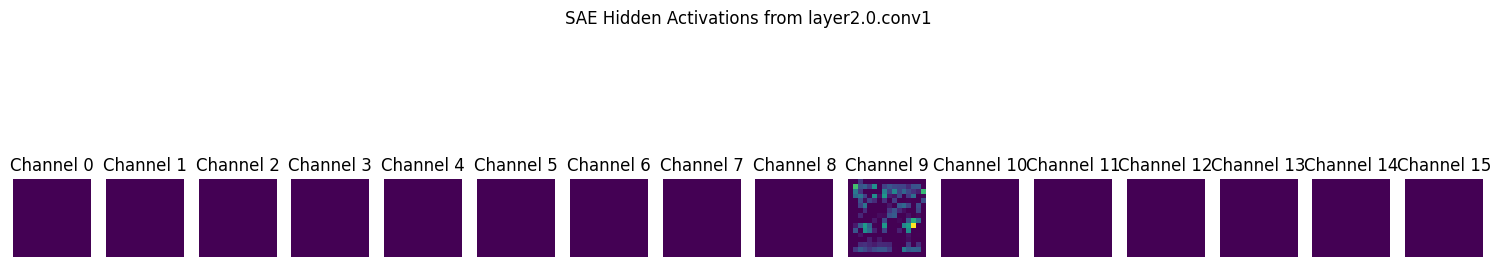

In [ ]:
plot_sae_hidden_activations(
    sae=sae_dict['layer2.0.conv1'],
    extractor=extractor,
    model=model,
    data_loader=held_out_loader,
    layer_name='layer2.0.conv1',
    idx=0,                # visualize the first image in batch
    num_channels=16# show first 8 latent channels
)


# FGSM Attack

In [ ]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)

    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    perturbed = images + epsilon * images.grad.data.sign()
    perturbed = torch.clamp(perturbed, 0, 1)  # keep in valid image range
    return perturbed.detach()


In [ ]:
def add_gaussian_noise(images, epsilon):
    # Generate Gaussian noise
    noise = torch.randn_like(images)

    # Normalize to unit max abs (L∞ norm = 1)
    max_abs = noise.abs().amax(dim=(1, 2, 3), keepdim=True)
    noise = noise / (max_abs + 1e-8)  # avoid division by zero

    # Scale to have L∞ norm of epsilon
    noise = noise * epsilon

    # Add and clip
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
    return noisy_images


In [ ]:
adversarial_images = []
adversarial_labels = []

model.eval()
epsilon = 0.03

for imgs, labels in tqdm(held_out_loader, desc="Generating FGSM adversarial inputs"):
    imgs = imgs.to(device)
    labels = labels.to(device)
    adv_imgs = fgsm_attack(model, imgs, labels, epsilon)
    adversarial_images.append(adv_imgs.cpu())
    adversarial_labels.append(labels.cpu())

adv_dataset = torch.utils.data.TensorDataset(torch.cat(adversarial_images), torch.cat(adversarial_labels))
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)


Generating FGSM adversarial inputs: 100%|██████████| 118/118 [00:03<00:00, 37.19it/s]


In [ ]:
epsilon = 0.03  # same as FGSM

noisy_images = []
noisy_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(held_out_loader, desc="Generating L∞-bounded Gaussian noise inputs"):
        imgs = imgs.to(device)
        noisy = add_gaussian_noise(imgs, epsilon)
        noisy_images.append(noisy.cpu())
        noisy_labels.append(labels)

noisy_dataset = torch.utils.data.TensorDataset(torch.cat(noisy_images), torch.cat(noisy_labels))
noisy_loader = DataLoader(noisy_dataset, batch_size=32, shuffle=False)


Generating L∞-bounded Gaussian noise inputs: 100%|██████████| 118/118 [00:01<00:00, 62.60it/s]


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def extract_sae_latents(sae_dict, extractor, model, data_loader, target_class, class_names, max_samples=200):
    latent_dict = {layer: [] for layer in sae_dict}
    labels = []

    model.eval()
    extractor.eval()

    count = 0
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            mask = lbls == class_names.index(target_class)
            if not mask.any(): continue

            imgs = imgs[mask]
            if imgs.size(0) == 0: continue

            feats = extractor(imgs)
            for name in sae_dict:
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                z_flat = z.view(z.size(0), -1)  # shape: [B, C × H × W]
                latent_dict[name].append(z_flat.cpu())

            labels += [target_class] * imgs.size(0)
            count += imgs.size(0)
            if count >= max_samples: break

    return {k: torch.cat(v) for k, v in latent_dict.items()}, labels


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_all_noisy_vs_adv_tsne_layers(sae_dict, extractor, model, noisy_loader, adv_loader, max_samples=300):
    def get_latents(sae, layer_name, loader):
        zs = []
        with torch.no_grad():
            for imgs, _ in loader:
                imgs = imgs.to(device)
                feats = extractor(imgs)
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                #z = z.view(z.size(0), -1)  # shape: [B, C × H × W]
                z = z.mean(dim=(2, 3))
                zs.append(z.cpu())
                if len(zs) * imgs.size(0) >= max_samples:
                    break
        return torch.cat(zs, dim=0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        z_noisy = get_latents(sae, layer_name, noisy_loader)
        z_adv   = get_latents(sae, layer_name, adv_loader)

        combined = torch.cat([z_noisy, z_adv], dim=0)

        tsne = TSNE(n_components=2, perplexity=5, init='pca', random_state=42)
        embedded = tsne.fit_transform(combined)

        n = z_noisy.shape[0]
        plt.figure(figsize=(6, 5))
        plt.scatter(embedded[:n, 0], embedded[:n, 1], label='Noisy', color='blue', alpha=0.6)
        plt.scatter(embedded[n:, 0], embedded[n:, 1], label='Adversarial', color='red', alpha=0.6)
        plt.title(f"t-SNE of SAE Latents — {layer_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

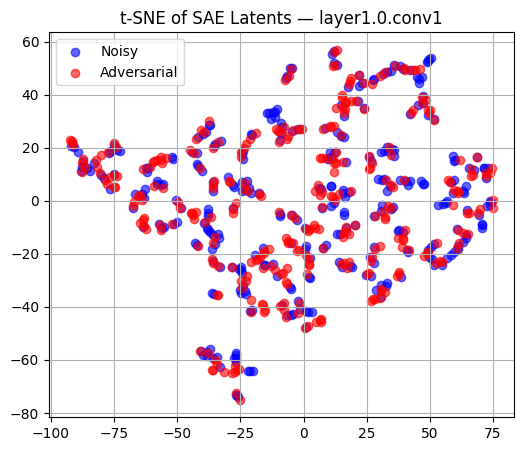

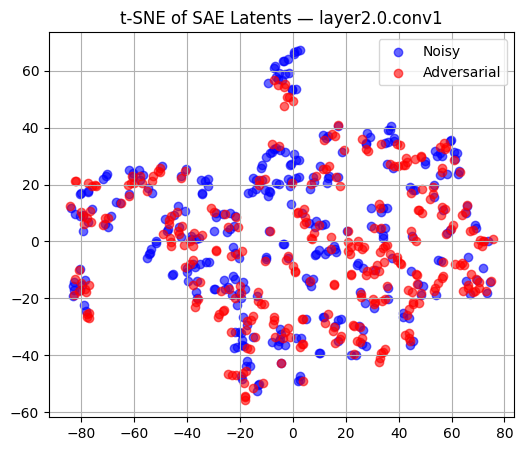

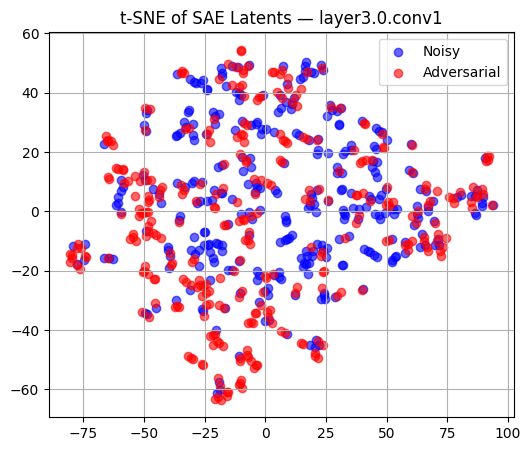

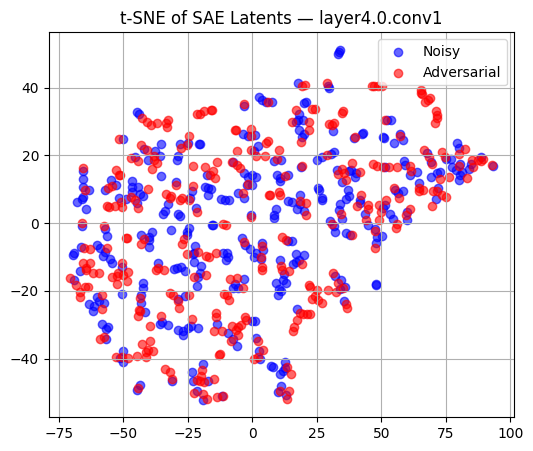

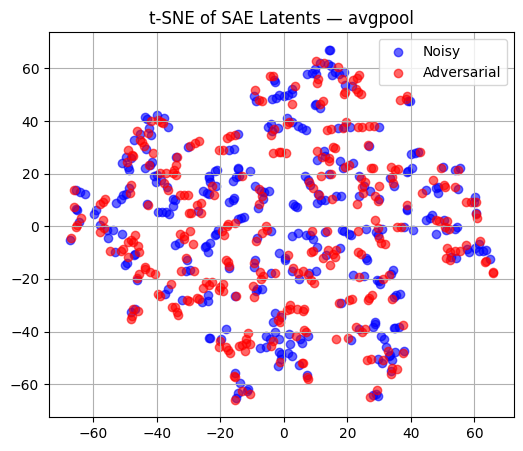

In [ ]:
plot_all_noisy_vs_adv_tsne_layers(
    sae_dict=sae_dict,
    extractor=extractor,
    model=model,
    noisy_loader=noisy_loader,
    adv_loader=adv_loader,
    max_samples=300
)

In [ ]:
def plot_classwise_misclassification_tsne(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, max_samples=300
):
    def get_filtered_latents(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)

                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                imgs = imgs[mask]
                feats = extractor(imgs)
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                pool = torch.nn.AdaptiveAvgPool2d((4, 4))
                z = pool(z)  # Output: [B, C, 2, 2]
                z = z.flatten(start_dim=1)  # Output: [B, 4*C]
                z = F.normalize(z, p=2, dim=1)
                zs.append(z.cpu())

                if sum([z.shape[0] for z in zs]) >= max_samples:
                    break

        return torch.cat(zs, dim=0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        # ✅ Noisy inputs correctly classified as target_class
        z_noisy = get_filtered_latents(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )

        # ✅ Adversarial inputs misclassified as target_class
        z_adv = get_filtered_latents(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if len(z_noisy) == 0 or len(z_adv) == 0:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        combined = torch.cat([z_noisy, z_adv], dim=0)

        #tsne = TSNE(n_components=2, perplexity=40, init='random', random_state=42) works decently well
        tsne = TSNE(n_components=2, perplexity=30, init='random', early_exaggeration=40, random_state=42)
        embedded = tsne.fit_transform(combined)

        n = z_noisy.shape[0]
        plt.figure(figsize=(6, 5))
        plt.scatter(embedded[:n, 0], embedded[:n, 1], label='Noisy (correct)', color='blue', alpha=0.6)
        plt.scatter(embedded[n:, 0], embedded[n:, 1], label='Adversarial (misclassified)', color='red', alpha=0.6)
        plt.title(f"SAE latent t-SNE — {class_names[target_class_index]} ({layer_name})")
        plt.legend()
        plt.grid(True)
        plt.show()


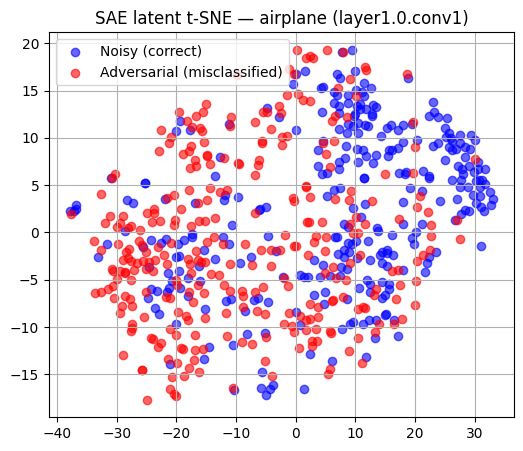

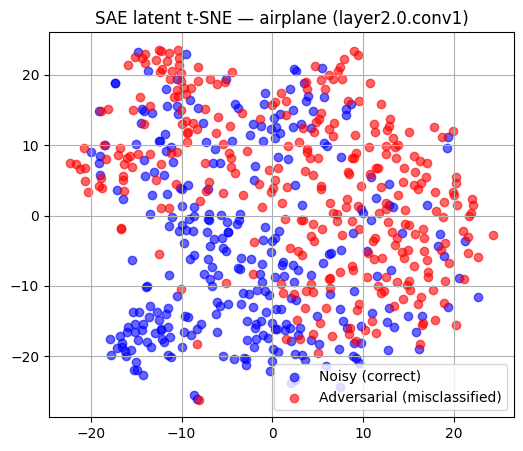

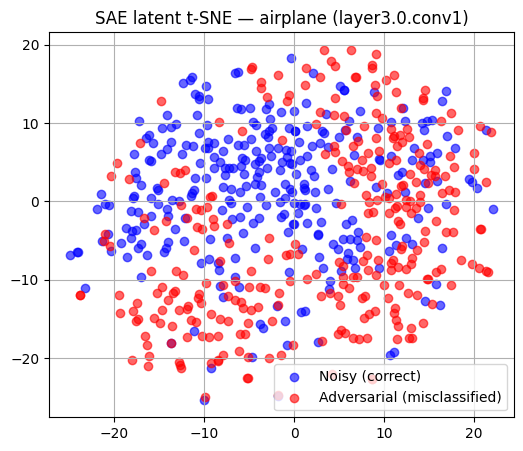

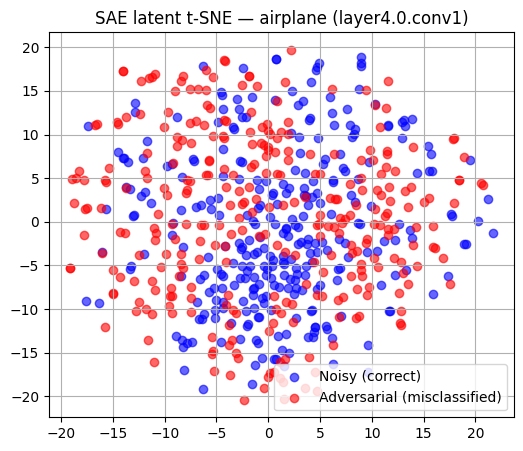

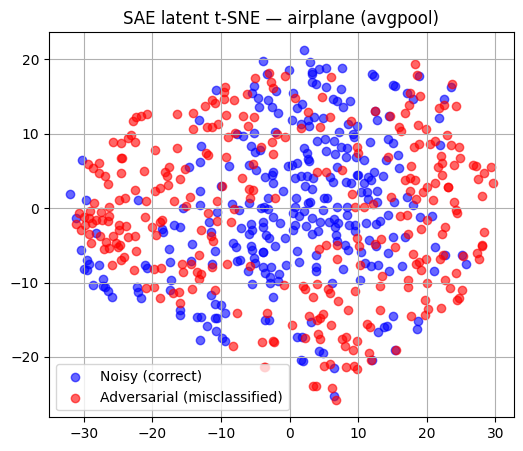

In [ ]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

target_class = "airplane"
target_index = class_names.index(target_class)

plot_classwise_misclassification_tsne(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    target_class_index=target_index,
    class_names=class_names,
    max_samples=300
)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_classwise_misclassification_pca(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, max_samples=300
):
    def get_filtered_latents(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)

                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                imgs = imgs[mask]
                feats = extractor(imgs)
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                pool = torch.nn.AdaptiveAvgPool2d((4, 4))
                z = pool(z)  # Output: [B, C, 2, 2]
                z = z.flatten(start_dim=1)  # Output: [B, 4*C]
                z = F.normalize(z, p=2, dim=1)
                zs.append(z.cpu())

                if sum(z.shape[0] for z in zs) >= max_samples:
                    break

        return torch.cat(zs, dim=0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        z_noisy = get_filtered_latents(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )

        z_adv = get_filtered_latents(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if len(z_noisy) == 0 or len(z_adv) == 0:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        combined = torch.cat([z_noisy, z_adv], dim=0)

        # ✅ PCA instead of t-SNE
        pca = PCA(n_components=2)
        embedded = pca.fit_transform(combined)

        n = z_noisy.shape[0]
        plt.figure(figsize=(6, 5))
        plt.scatter(embedded[:n, 0], embedded[:n, 1], label='Noisy (correct)', color='blue', alpha=0.6)
        plt.scatter(embedded[n:, 0], embedded[n:, 1], label='Adversarial (misclassified)', color='red', alpha=0.6)
        plt.title(f"SAE latent PCA — {class_names[target_class_index]} ({layer_name})")
        plt.legend()
        plt.grid(True)
        plt.show()


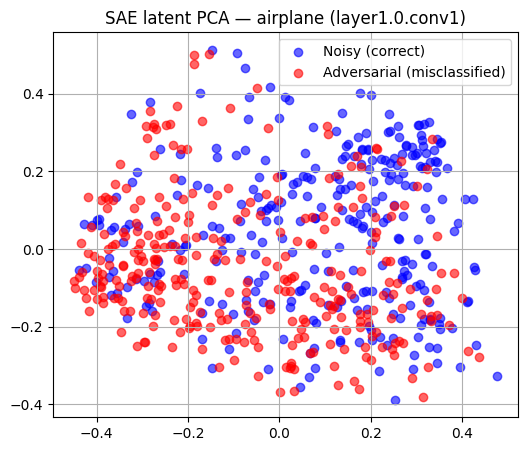

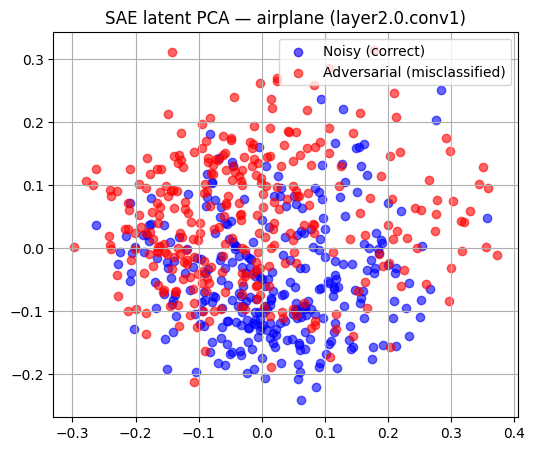

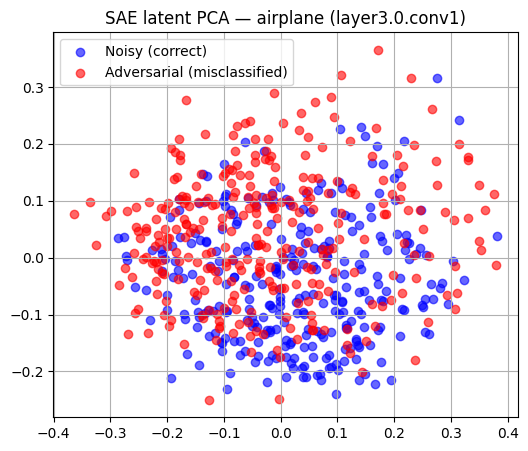

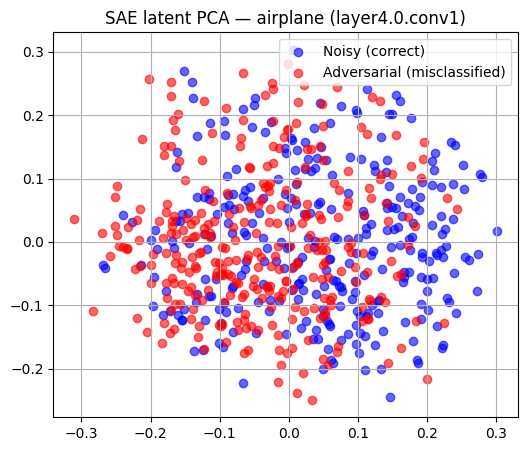

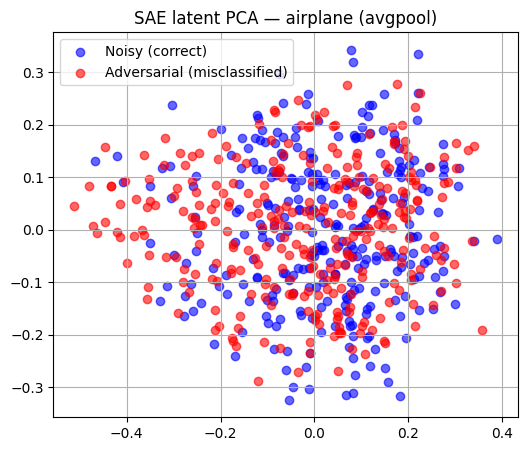

In [ ]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

target_class = "airplane"
target_index = class_names.index(target_class)

plot_classwise_misclassification_pca(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    target_class_index=target_index,
    class_names=class_names,
    max_samples=300
)


In [ ]:
import matplotlib.pyplot as plt
import torch
import umap
from sklearn.metrics import silhouette_score

def plot_classwise_misclassification_umap(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, max_samples=300
):
    def get_filtered_latents(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)

                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                imgs = imgs[mask]
                feats = extractor(imgs)
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                #z = z.mean(dim=(2, 3))  # Global average pool: [B, C]
                pool = torch.nn.AdaptiveAvgPool2d((4, 4))
                z = pool(z)  # Output: [B, C, 2, 2]
                z = z.flatten(start_dim=1)  # Output: [B, 4*C]
                z = F.normalize(z, p=2, dim=1)
                zs.append(z.cpu())

                if sum(z.shape[0] for z in zs) >= max_samples:
                    break

        return torch.cat(zs, dim=0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        z_noisy = get_filtered_latents(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )

        z_adv = get_filtered_latents(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if len(z_noisy) == 0 or len(z_adv) == 0:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        combined = torch.cat([z_noisy, z_adv], dim=0)
        labels = [0] * len(z_noisy) + [1] * len(z_adv)

        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=3,
            min_dist=0.001,
            spread=5,
            metric='cosine',
            random_state=42
        )
        embedded = reducer.fit_transform(combined.numpy())

        # Compute silhouette score
        silhouette = silhouette_score(embedded, labels)

        # Compute mean points
        noisy_mean = embedded[:len(z_noisy)].mean(axis=0)
        adv_mean = embedded[len(z_noisy):].mean(axis=0)

        # Plot
        plt.figure(figsize=(6, 5))
        plt.scatter(embedded[:len(z_noisy), 0], embedded[:len(z_noisy), 1], label='Noisy (correct)', color='blue', alpha=0.6)
        plt.scatter(embedded[len(z_noisy):, 0], embedded[len(z_noisy):, 1], label='Adversarial (misclassified)', color='red', alpha=0.6)

        # Overlay mean points
        plt.scatter(noisy_mean[0], noisy_mean[1], color='blue', edgecolor='black', s=100, marker='o', label='Noisy Mean')
        plt.scatter(adv_mean[0], adv_mean[1], color='red', edgecolor='black', s=100, marker='X', label='Adversarial Mean')

        plt.title(f"SAE latent UMAP — {class_names[target_class_index]} ({layer_name})\nSilhouette = {silhouette:.3f}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


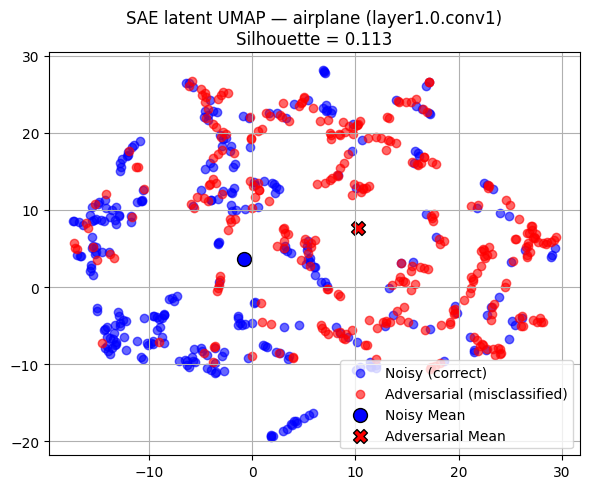

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


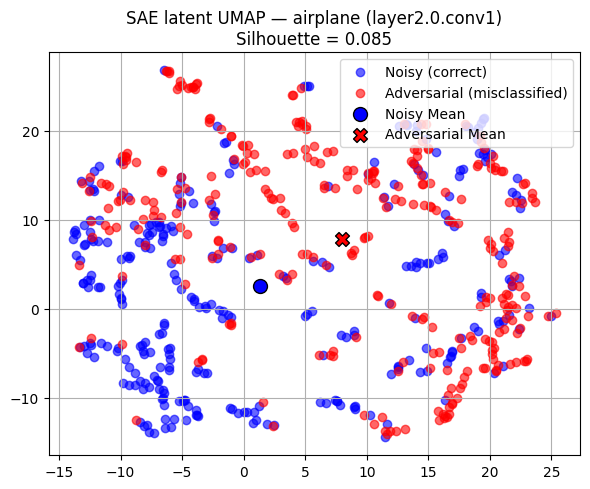

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

In [ ]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

target_class = "airplane"
target_index = class_names.index(target_class)

plot_classwise_misclassification_umap(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    target_class_index=target_index,
    class_names=class_names,
    max_samples=300
)


# Delta of target class and adversary detecting target class.

In [ ]:
def get_top_diff_channels_abs_sorted(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, top_k=10, max_samples=300
):
    import torch

    def get_channelwise_means(sae, layer_name, loader, condition_fn):
        activations = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                imgs = imgs[mask]
                feats = extractor(imgs)
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                z = z.flatten(start_dim=1)                     # [B, C * H * W]
                activations.append(z.cpu())

                if sum(z.shape[0] for z in activations) >= max_samples:
                    break

        if not activations:
            return None
        return torch.cat(activations, dim=0).mean(dim=0)  # [C * H * W]

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        # Clean examples classified as target class
        mean_noisy = get_channelwise_means(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )

        # Adversarial examples misclassified as target class
        mean_adv = get_channelwise_means(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if mean_noisy is None or mean_adv is None:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        delta = mean_adv - mean_noisy
        abs_delta = delta.abs()
        top_indices = torch.topk(abs_delta, k=top_k).indices

        print(f"\n[{layer_name}] Top {top_k} neurons (misclassified as '{class_names[target_class_index]}') with largest |Δ| (adv - clean):")
        for idx in top_indices:
            d = delta[idx].item()
            adv_val = mean_adv[idx].item()
            clean_val = mean_noisy[idx].item()
            sign = "↑" if d > 0 else "↓"
            print(f"  Neuron {idx.item():>6}: Δ = {d:+.4f} {sign} (Adv = {adv_val:.4f}, Clean = {clean_val:.4f})")


In [ ]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

target_class = "airplane"
target_index = class_names.index(target_class)

get_top_diff_channels_abs_sorted(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    target_class_index=target_index,
    class_names=class_names,
    max_samples=300
)



[layer1.0.conv1] Top 10 neurons (misclassified as 'airplane') with largest |Δ| (adv - clean):
  Neuron 1013933: Δ = -1.2624 ↓ (Adv = 1.4052, Clean = 2.6675)
  Neuron 1013936: Δ = -1.2551 ↓ (Adv = 1.4145, Clean = 2.6695)
  Neuron 1013934: Δ = -1.2522 ↓ (Adv = 1.4029, Clean = 2.6551)
  Neuron 1013964: Δ = -1.2522 ↓ (Adv = 1.3328, Clean = 2.5850)
  Neuron 1013966: Δ = -1.2510 ↓ (Adv = 1.3303, Clean = 2.5813)
  Neuron 1013935: Δ = -1.2431 ↓ (Adv = 1.4009, Clean = 2.6440)
  Neuron 1013965: Δ = -1.2399 ↓ (Adv = 1.3410, Clean = 2.5809)
  Neuron 1013963: Δ = -1.2371 ↓ (Adv = 1.3457, Clean = 2.5828)
  Neuron 1013938: Δ = -1.2338 ↓ (Adv = 1.4348, Clean = 2.6687)
  Neuron 1013903: Δ = -1.2329 ↓ (Adv = 1.4879, Clean = 2.7208)

[layer2.0.conv1] Top 10 neurons (misclassified as 'airplane') with largest |Δ| (adv - clean):
  Neuron 139574: Δ = -2.4529 ↓ (Adv = 5.3186, Clean = 7.7715)
  Neuron 1753129: Δ = +2.4070 ↑ (Adv = 4.5994, Clean = 2.1924)
  Neuron 1753127: Δ = +2.3982 ↑ (Adv = 4.4936, Clean = 

# Delta of "true" adversary class and noisy class inputs.

In [ ]:
def get_true_class_diff_channels_abs_sorted(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, top_k=10, max_samples=300
):
    import torch

    def get_channelwise_means(sae, layer_name, loader, condition_fn):
        activations = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                imgs = imgs[mask]
                feats = extractor(imgs)
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                z = z.flatten(start_dim=1)                     # [B, C * H * W]
                activations.append(z.cpu())

                if sum(z.shape[0] for z in activations) >= max_samples:
                    break

        if not activations:
            return None  # Handle edge case where no samples match
        return torch.cat(activations, dim=0).mean(dim=0)  # [C * H * W]

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        # Clean examples: correctly classified with true label
        mean_noisy = get_channelwise_means(
            sae, layer_name, noisy_loader,
            lambda pred, true: (true == target_class_index) & (pred == true)
        )

        # Adversarial examples: misclassified, but same true label
        mean_adv = get_channelwise_means(
            sae, layer_name, adv_loader,
            lambda pred, true: (true == target_class_index) & (pred != true)
        )

        if mean_noisy is None or mean_adv is None:
            print(f"[{layer_name}] Skipping — not enough data for class '{class_names[target_class_index]}'")
            continue

        delta = mean_adv - mean_noisy               # [C * H * W]
        abs_delta = delta.abs()                     # [C * H * W]
        top_indices = torch.topk(abs_delta, k=top_k).indices

        print(f"\n[{layer_name}] Top {top_k} neurons (true class = '{class_names[target_class_index]}') with largest |Δ| (adv - clean):")
        for idx in top_indices:
            d = delta[idx].item()
            adv_val = mean_adv[idx].item()
            clean_val = mean_noisy[idx].item()
            sign = "↑" if d > 0 else "↓"
            print(f"  Neuron {idx.item():>6}: Δ = {d:+.4f} {sign} (Adv = {adv_val:.4f}, Clean = {clean_val:.4f})")


In [ ]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

target_class = "airplane"
target_index = class_names.index(target_class)

get_true_class_diff_channels_abs_sorted(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    target_class_index=target_index,
    class_names=class_names,
    max_samples=300
)



[layer1.0.conv1] Top 10 neurons (true class = 'airplane') with largest |Δ| (adv - clean):
  Neuron 1212513: Δ = +0.4572 ↑ (Adv = 1.1559, Clean = 0.6987)
  Neuron 1212481: Δ = +0.4001 ↑ (Adv = 1.0818, Clean = 0.6817)
  Neuron 1212545: Δ = +0.3790 ↑ (Adv = 1.0813, Clean = 0.7023)
  Neuron 1624614: Δ = -0.3215 ↓ (Adv = 1.0405, Clean = 1.3620)
  Neuron 1624613: Δ = -0.3070 ↓ (Adv = 1.0012, Clean = 1.3083)
  Neuron 1624502: Δ = -0.3058 ↓ (Adv = 0.9959, Clean = 1.3016)
  Neuron 4024360: Δ = +0.3018 ↑ (Adv = 0.9790, Clean = 0.6773)
  Neuron 1213025: Δ = +0.3015 ↑ (Adv = 1.0481, Clean = 0.7466)
  Neuron 1624615: Δ = -0.2911 ↓ (Adv = 1.0337, Clean = 1.3248)
  Neuron 1212769: Δ = +0.2790 ↑ (Adv = 1.2132, Clean = 0.9342)

[layer2.0.conv1] Top 10 neurons (true class = 'airplane') with largest |Δ| (adv - clean):
  Neuron  96801: Δ = +4.4750 ↑ (Adv = 7.5206, Clean = 3.0456)
  Neuron  96785: Δ = +3.6752 ↑ (Adv = 5.5194, Clean = 1.8442)
  Neuron  97006: Δ = +3.4022 ↑ (Adv = 4.7977, Clean = 1.3954)
  

In [ ]:
def compare_bidirectional_adversarial_transitions(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    from_class_idx, to_class_idx, class_names,
    epsilon=1e-3, max_samples=300, top_k=100
):
    import torch
    import matplotlib.pyplot as plt

    def get_mean_activation(sae, layer_name, loader, condition_fn):
        activations = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                feats = extractor(imgs[mask])
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                z = z.flatten(start_dim=1)                     # [B, C*H*W]
                activations.append(z.cpu())

                if sum(z.shape[0] for z in activations) >= max_samples:
                    break

        return torch.cat(activations, dim=0).mean(dim=0) if activations else None

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        clean_to_class = get_mean_activation(
            sae, layer_name, noisy_loader,
            lambda pred, true: (true == to_class_idx) & (pred == true)
        )

        adv_from_fromclass = get_mean_activation(
            sae, layer_name, adv_loader,
            lambda pred, true: (true == from_class_idx) & (pred == to_class_idx)
        )

        adv_from_toclass = get_mean_activation(
            sae, layer_name, adv_loader,
            lambda pred, true: (true == to_class_idx) & (pred == from_class_idx)
        )

        if None in (clean_to_class, adv_from_fromclass, adv_from_toclass):
            print(f"[{layer_name}] Skipping — not enough data.")
            continue

        delta_from = adv_from_fromclass - clean_to_class
        delta_to   = adv_from_toclass - clean_to_class

        # Plot relative changes for top-k active clean_to_class neurons
        top_indices = torch.topk(clean_to_class, k=top_k).indices

        plt.figure(figsize=(10, 4))
        plt.plot(delta_from[top_indices], label=f"{class_names[from_class_idx]} → {class_names[to_class_idx]}", color='red')
        plt.plot(delta_to[top_indices], label=f"{class_names[to_class_idx]} → {class_names[from_class_idx]}", color='blue')
        plt.axhline(0, linestyle='--', color='gray')
        plt.title(f"Adversarial Δ from Clean {class_names[to_class_idx]} — {layer_name}")
        plt.xlabel("Neuron Index (top-k by clean activation)")
        plt.ylabel("Δ (adv - clean)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


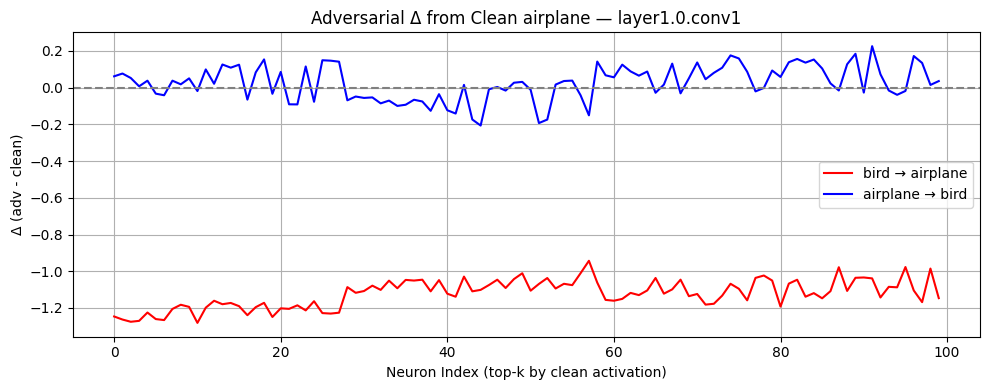

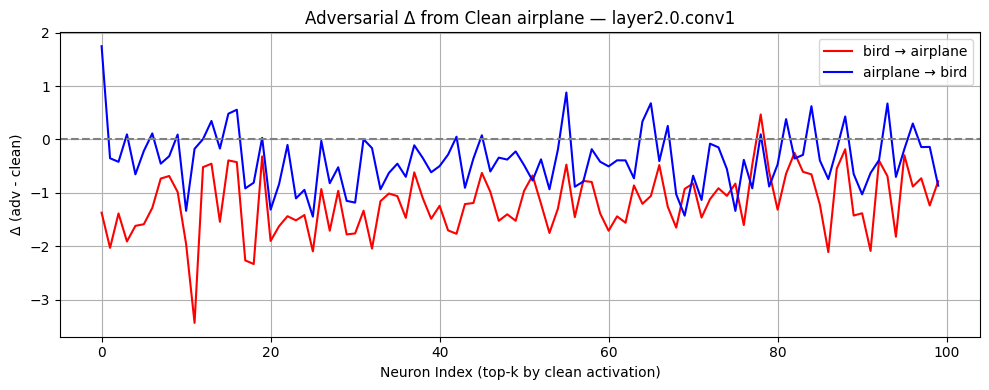

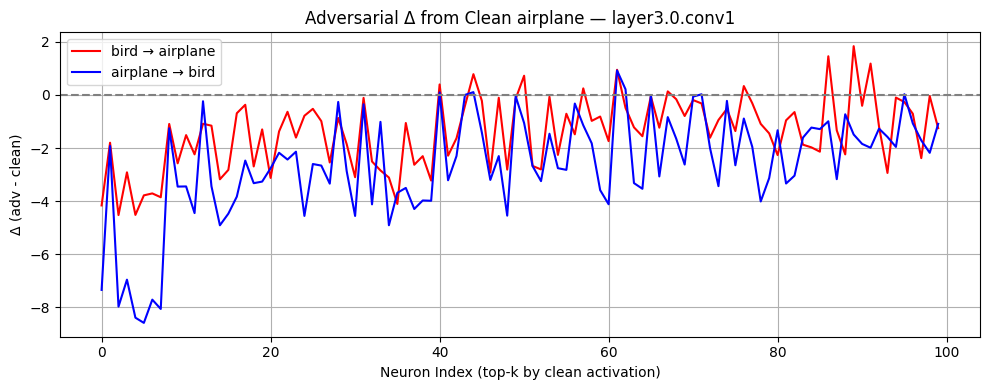

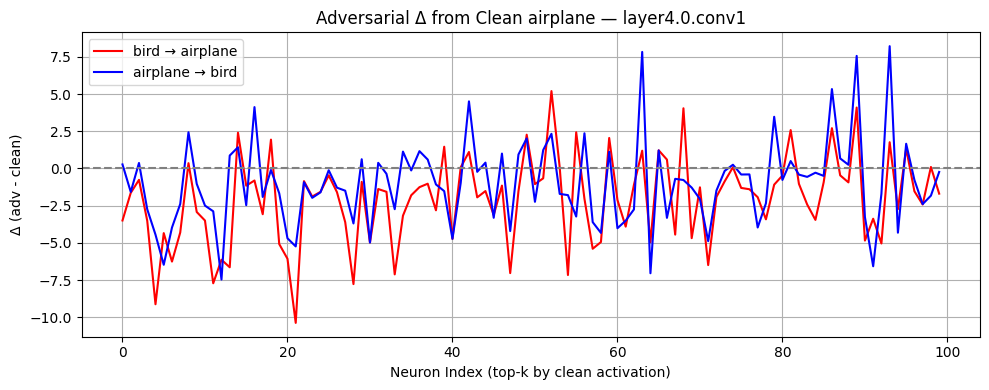

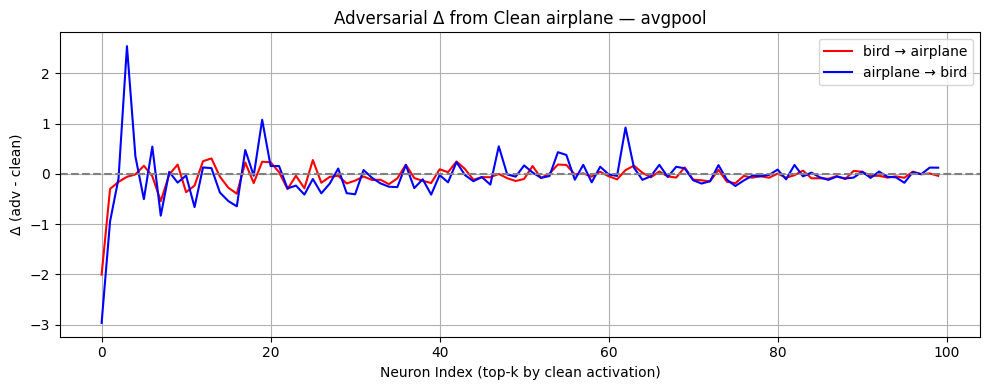

In [ ]:
compare_bidirectional_adversarial_transitions(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    from_class_idx=class_names.index("bird"),
    to_class_idx=class_names.index("airplane"),
    class_names=class_names
)


From 3 Random Classes -> To Select Class

In [ ]:
import torch
import matplotlib.pyplot as plt
from random import sample

def compare_multiple_adversarial_transitions_to_one(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    to_class_idx, class_names,
    epsilon=1e-3, max_samples=300, top_k=100
):
    def get_mean_activation(sae, layer_name, loader, condition_fn):
        activations = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue
                feats = extractor(imgs[mask])
                z = sae.relu1(sae.encoder(feats[layer_name]))
                z = z.flatten(start_dim=1).cpu()
                activations.append(z)
                if sum(z.shape[0] for z in activations) >= max_samples:
                    break
        return torch.cat(activations, dim=0).mean(dim=0) if activations else None

    # Choose 3 random other classes as the "from" classes
    all_indices = list(range(len(class_names)))
    from_classes = sample([i for i in all_indices if i != to_class_idx], 3)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        clean_to_class = get_mean_activation(
            sae, layer_name, noisy_loader,
            lambda pred, true: (true == to_class_idx) & (pred == true)
        )

        if clean_to_class is None:
            print(f"[{layer_name}] Skipping — not enough clean data.")
            continue

        top_indices = torch.topk(clean_to_class, k=top_k).indices

        plt.figure(figsize=(10, 4))

        for from_class in from_classes:
            adv_from_class = get_mean_activation(
                sae, layer_name, adv_loader,
                lambda pred, true: (true == from_class) & (pred == to_class_idx)
            )
            if adv_from_class is None:
                continue

            delta = adv_from_class - clean_to_class
            plt.plot(
                delta[top_indices],
                label=f"{class_names[from_class]} → {class_names[to_class_idx]}"
            )

        plt.axhline(0, linestyle='--', color='gray')
        plt.title(f"Adversarial Δ to {class_names[to_class_idx]} — {layer_name}")
        plt.xlabel("Neuron Index (top-k by clean activation)")
        plt.ylabel("Δ (adv - clean)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


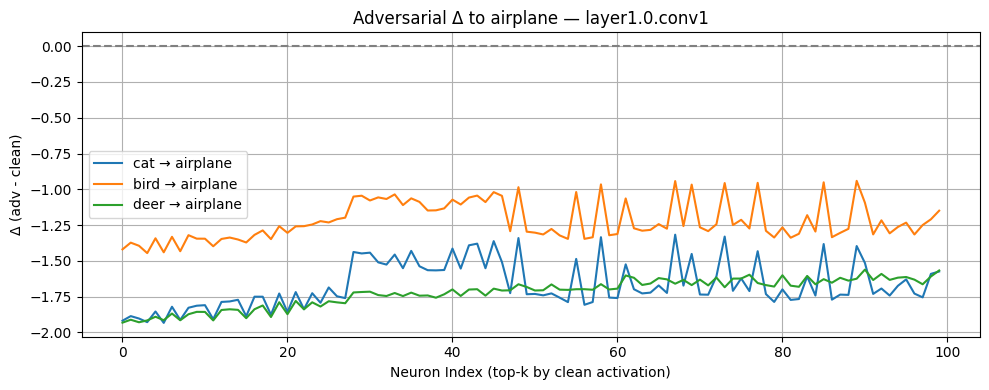

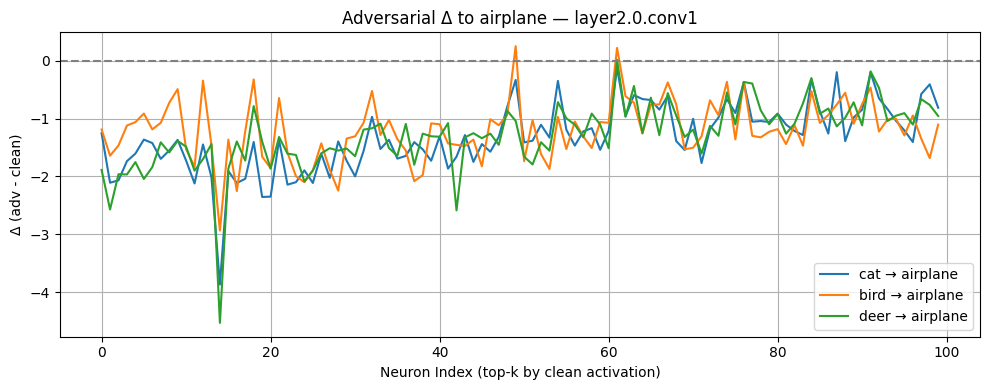

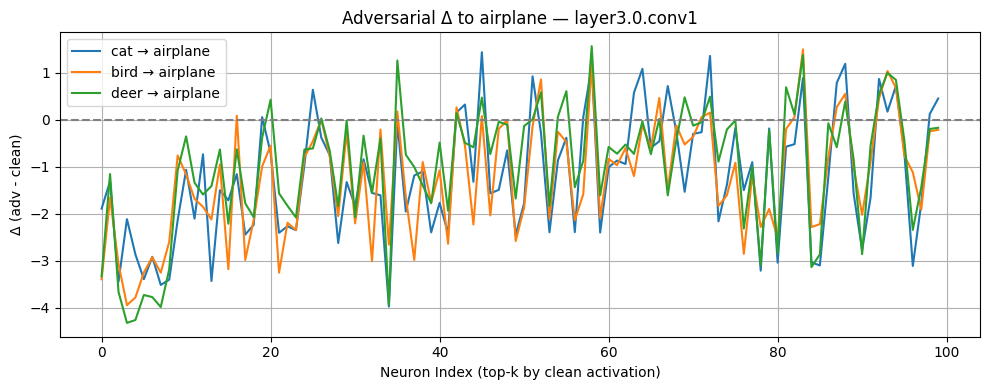

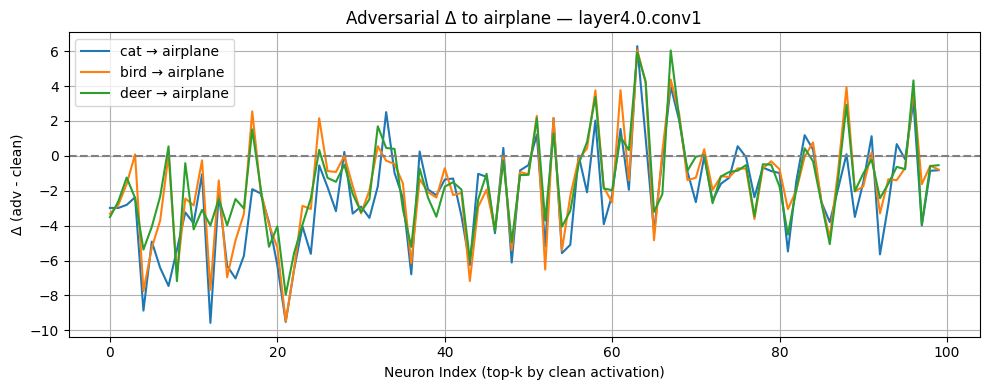

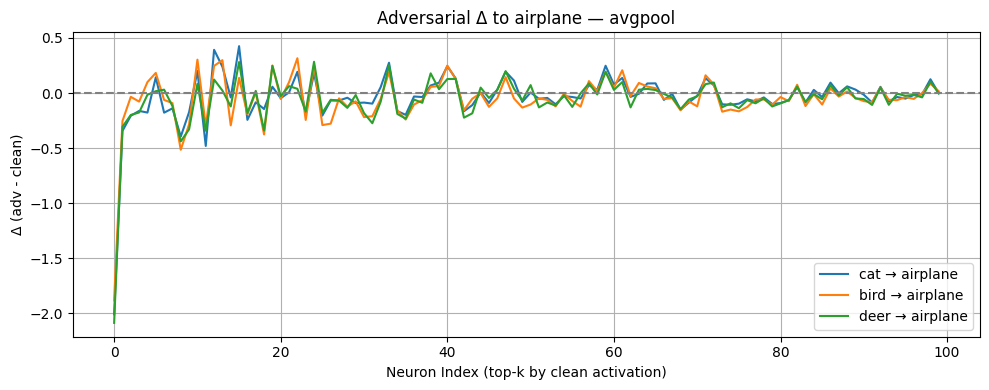

In [ ]:
compare_multiple_adversarial_transitions_to_one(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    to_class_idx=class_names.index("airplane"),  # Replace with any target class
    class_names=class_names,
    top_k=100
)


# Delta of Adversary - Misclassified Class vs Original - Misclassified Class


In [ ]:
import torch
import matplotlib.pyplot as plt

def compare_adv_and_natural_delta_single(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    from_class_idx, to_class_idx, class_names,
    max_samples=300, top_k=100
):
    device = next(model.parameters()).device

    def get_mean_activation(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any():
                    continue

                feats = extractor(imgs[mask])
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                z = z.flatten(start_dim=1).cpu()               # [B, C*H*W]
                zs.append(z)
                if sum(z.shape[0] for z in zs) >= max_samples:
                    break

        if not zs:
            return None
        return torch.cat(zs, dim=0).mean(dim=0)

    for layer_name, sae in sae_dict.items():
        # mean activation of clean target
        mu_clean_tgt = get_mean_activation(
            sae, layer_name, noisy_loader,
            lambda p,t: (t==to_class_idx)&(p==t)
        )
        if mu_clean_tgt is None:
            print(f"[{layer_name}] no clean‐target samples, skipping")
            continue

        # mean activation of clean source
        mu_clean_src = get_mean_activation(
            sae, layer_name, noisy_loader,
            lambda p,t: (t==from_class_idx)&(p==t)
        )
        if mu_clean_src is None:
            print(f"[{layer_name}] no clean‐source samples, skipping")
            continue

        # mean activation of adversarial source→target
        mu_adv_src2t = get_mean_activation(
            sae, layer_name, adv_loader,
            lambda p,t: (t==from_class_idx)&(p==to_class_idx)
        )
        if mu_adv_src2t is None:
            print(f"[{layer_name}] no adv‐source→target samples, skipping")
            continue

        # pick top‐k neurons by clean‐target activation
        topk = torch.topk(mu_clean_tgt, k=top_k).indices

        # compute deltas on those neurons
        delta_clean = (mu_clean_src - mu_clean_tgt)[topk].numpy()
        delta_adv   = (mu_adv_src2t   - mu_clean_tgt)[topk].numpy()

        # plot
        plt.figure(figsize=(8,3))
        plt.plot(delta_clean, '--', label=f"Clean {class_names[from_class_idx]} ✓→ {class_names[to_class_idx]}")
        plt.plot(delta_adv,   '-',  label=f" Adv  {class_names[from_class_idx]} ✗→ {class_names[to_class_idx]}")
        plt.axhline(0, color='gray', linestyle='--', lw=1)
        plt.title(f"Δ Comparison [{layer_name}]")
        plt.xlabel(f"Neuron rank (top‐{top_k} of clean “{class_names[to_class_idx]}”)")
        plt.ylabel("Δ activation")
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


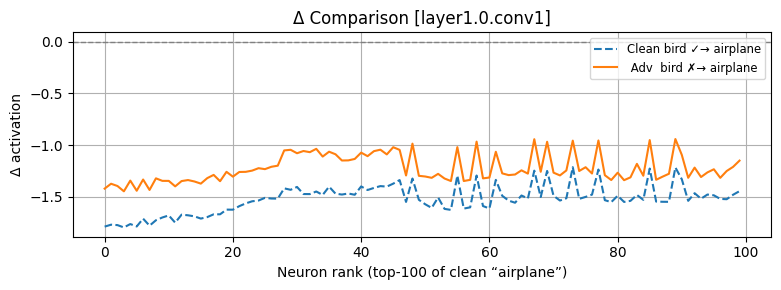

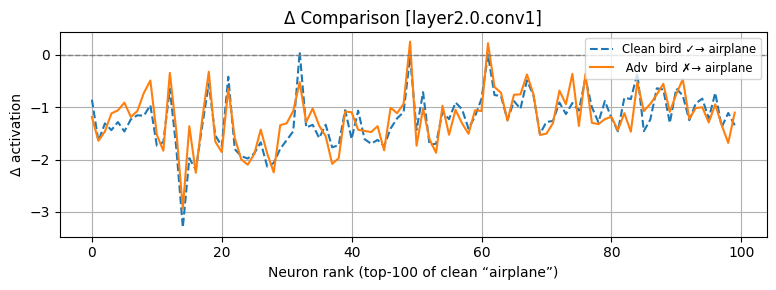

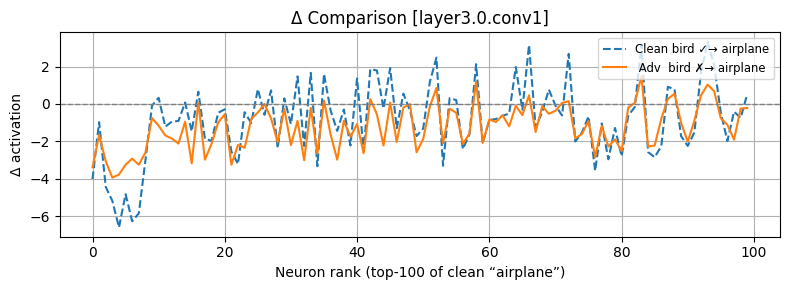

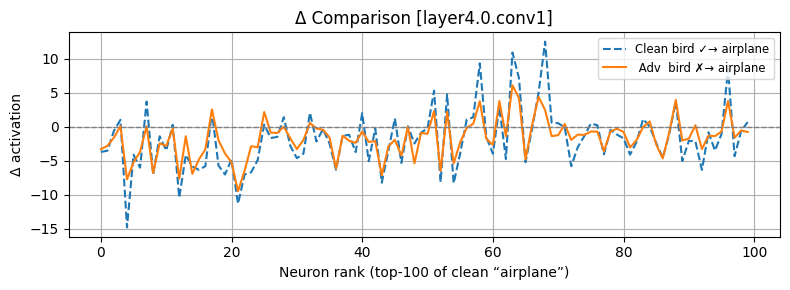

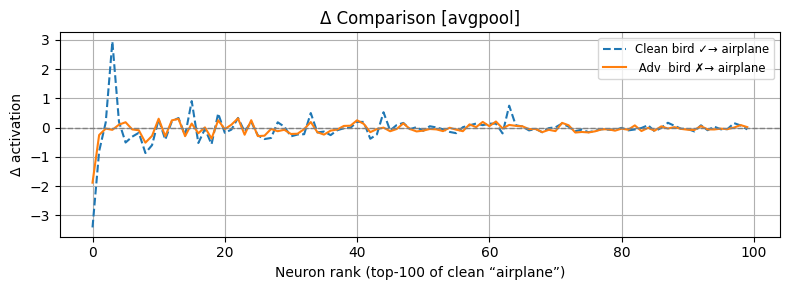

In [ ]:
compare_adv_and_natural_delta_single(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    from_class_idx= class_names.index("bird"),
    to_class_idx=class_names.index("airplane"),  # Replace with any target class
    class_names=class_names,
    top_k=100
)


# Channels only activated by adversary.

In [ ]:
def find_adversarial_only_channels(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names,
    epsilon=1e-3, delta=0.1, max_samples=300
):
    def get_mean_activations(sae, layer_name, loader, condition_fn):
        activations = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                imgs = imgs[mask]
                feats = extractor(imgs)
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                '''
                pool = torch.nn.AdaptiveAvgPool2d((16, 16))
                z = pool(z)  # Output: [B, C, 2, 2]
                z = z.flatten(start_dim=1)  # Output: [B, 4*C]
                '''
                z = z.flatten(start_dim = 1)
                activations.append(z.cpu())

                if sum(z.shape[0] for z in activations) >= max_samples:
                    break

        return torch.cat(activations, dim=0).mean(dim=0)  # [C]

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        mean_noisy = get_mean_activations(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )
        mean_adv = get_mean_activations(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        # Find channels inactive in normal (noisy) and active in adversarial
        mask = (mean_noisy < epsilon) & (mean_adv > delta)
        indices = torch.nonzero(mask).flatten()  # <- always returns 1D tensor

        print(f"\n[{layer_name}] Adversarial-only channels for class '{class_names[target_class_index]}':")
        if indices.numel() == 0:
            print("  ❌ None found with ε = {epsilon}, δ = {delta}")
        else:
            for idx in indices:
                print(f"  ✅ Channel {idx.item():>3}: Adv = {mean_adv[idx]:.4f}, Noisy = {mean_noisy[idx]:.4f}")


In [ ]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

target_class = "airplane"
target_index = class_names.index(target_class)

find_adversarial_only_channels(
    sae_dict, extractor, model,
    noisy_loader, adv_loader,
    target_class_index=target_index,
    class_names=class_names,
    max_samples=300,
    delta = 0.05
)



[layer1.0.conv1] Adversarial-only channels for class 'airplane':
  ❌ None found with ε = {epsilon}, δ = {delta}

[layer2.0.conv1] Adversarial-only channels for class 'airplane':
  ✅ Channel 1807635: Adv = 0.0731, Noisy = 0.0000

[layer3.0.conv1] Adversarial-only channels for class 'airplane':
  ✅ Channel 132101: Adv = 0.1865, Noisy = 0.0000
  ✅ Channel 351311: Adv = 0.0506, Noisy = 0.0008
  ✅ Channel 1047557: Adv = 0.2175, Noisy = 0.0000

[layer4.0.conv1] Adversarial-only channels for class 'airplane':
  ✅ Channel 348945: Adv = 0.0805, Noisy = 0.0000

[avgpool] Adversarial-only channels for class 'airplane':
  ❌ None found with ε = {epsilon}, δ = {delta}


# Top 1000 Neuron Reduction from clean

In [ ]:
def plot_classwise_misclassification_tsne_topk_flat(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, max_samples=300, top_k=100
):
    import torch
    import torch.nn.functional as F
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    def get_filtered_latents(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                feats = extractor(imgs[mask])
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                z = z.flatten(start_dim=1)                     # [B, C*H*W]
                zs.append(z.cpu())

                if sum(z.shape[0] for z in zs) >= max_samples:
                    break
        return torch.cat(zs, dim=0) if zs else torch.empty(0, 0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        z_noisy = get_filtered_latents(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )
        z_adv = get_filtered_latents(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if z_noisy.shape[0] == 0 or z_adv.shape[0] == 0:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        # 🧠 Select top-k neuron indices based on clean activations
        mean_clean = z_noisy.mean(dim=0)
        top_indices = torch.topk(mean_clean, k=top_k).indices

        z_noisy_top = z_noisy[:, top_indices]
        z_adv_top = z_adv[:, top_indices]
        combined = torch.cat([z_noisy_top, z_adv_top], dim=0)

        tsne = TSNE(n_components=2, perplexity=2, init='pca', random_state=42, metric="euclidean")
        embedded = tsne.fit_transform(combined)

        n = z_noisy_top.shape[0]
        plt.figure(figsize=(6, 5))
        plt.scatter(embedded[:n, 0], embedded[:n, 1], label='Noisy (correct)', color='blue', alpha=0.6)
        plt.scatter(embedded[n:, 0], embedded[n:, 1], label='Adversarial (misclassified)', color='red', alpha=0.6)
        plt.title(f"t-SNE (Top-{top_k} Neurons) — {class_names[target_class_index]} — {layer_name}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


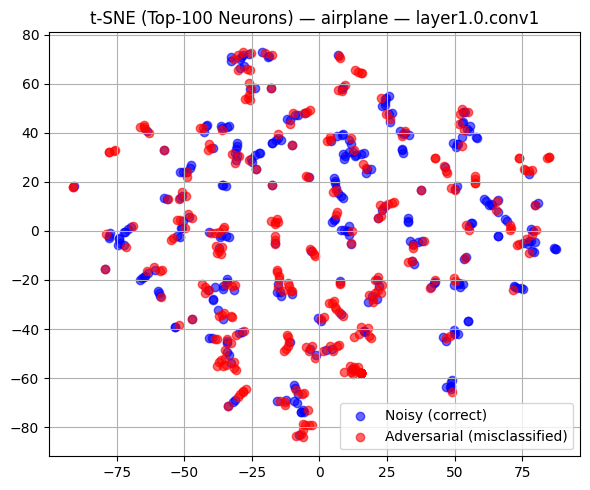

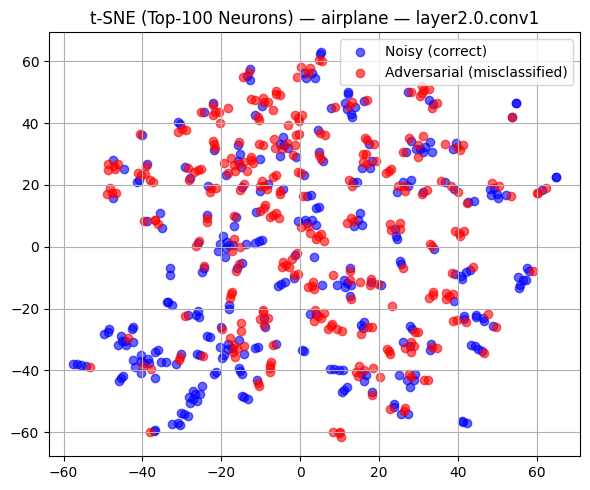

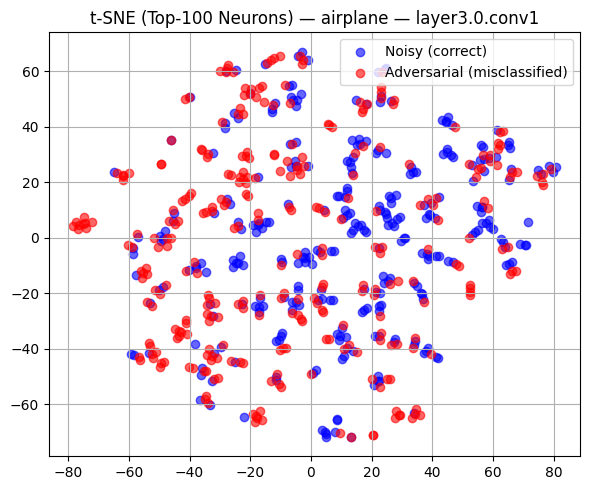

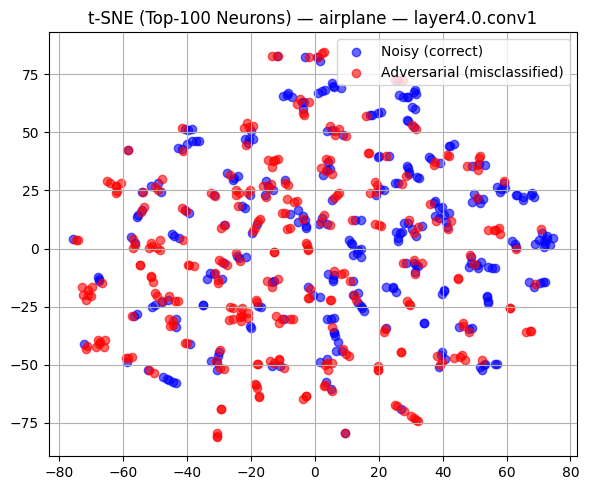

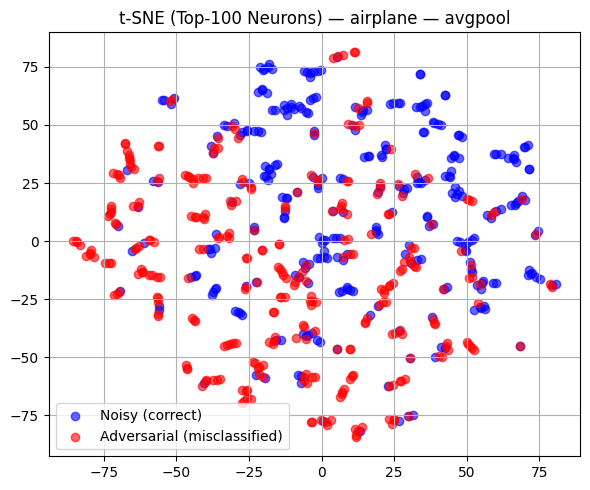

In [ ]:
# Make sure to define your target class and get its index
target_class = "airplane"
target_class_index = class_names.index(target_class)

# Now call the function using your model + data
plot_classwise_misclassification_tsne_topk_flat(
    sae_dict=sae_dict,
    extractor=extractor,
    model=model,
    noisy_loader=noisy_loader,
    adv_loader=adv_loader,
    target_class_index=target_class_index,
    class_names=class_names,
    max_samples=300,     # Number of clean + adv samples to use
    top_k=100           # Top-k neurons to select based on clean activation
)


In [ ]:
def plot_classwise_misclassification_pca_topk_flat(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, max_samples=300, top_k=100
):
    import torch
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    def get_filtered_latents(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                feats = extractor(imgs[mask])
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                z = z.flatten(start_dim=1)                     # [B, C*H*W]
                zs.append(z.cpu())

                if sum(z.shape[0] for z in zs) >= max_samples:
                    break
        return torch.cat(zs, dim=0) if zs else torch.empty(0, 0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        z_noisy = get_filtered_latents(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )
        z_adv = get_filtered_latents(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if z_noisy.shape[0] == 0 or z_adv.shape[0] == 0:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        # 🧠 Select top-k neuron indices based on clean activations
        mean_clean = z_noisy.mean(dim=0)
        top_indices = torch.topk(mean_clean, k=top_k).indices

        z_noisy_top = z_noisy[:, top_indices]
        z_adv_top = z_adv[:, top_indices]
        combined = torch.cat([z_noisy_top, z_adv_top], dim=0)

        # ✅ PCA instead of UMAP
        pca = PCA(n_components=2)
        embedded = pca.fit_transform(combined)

        n = z_noisy_top.shape[0]
        plt.figure(figsize=(6, 5))
        plt.scatter(embedded[:n, 0], embedded[:n, 1], label='Noisy (correct)', color='blue', alpha=0.6)
        plt.scatter(embedded[n:, 0], embedded[n:, 1], label='Adversarial (misclassified)', color='red', alpha=0.6)
        plt.title(f"PCA (Top-{top_k} Neurons) — {class_names[target_class_index]} — {layer_name}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


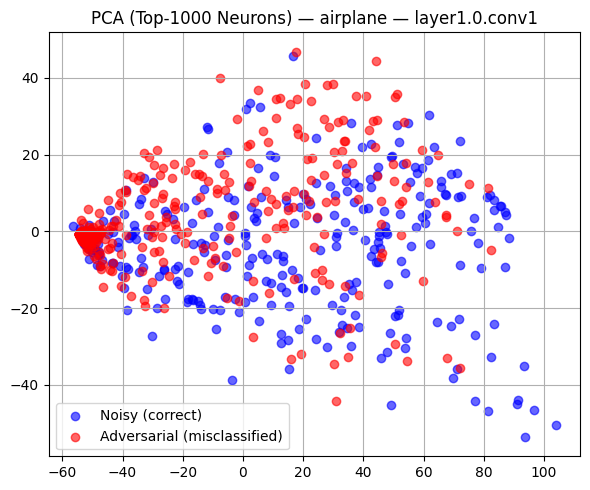

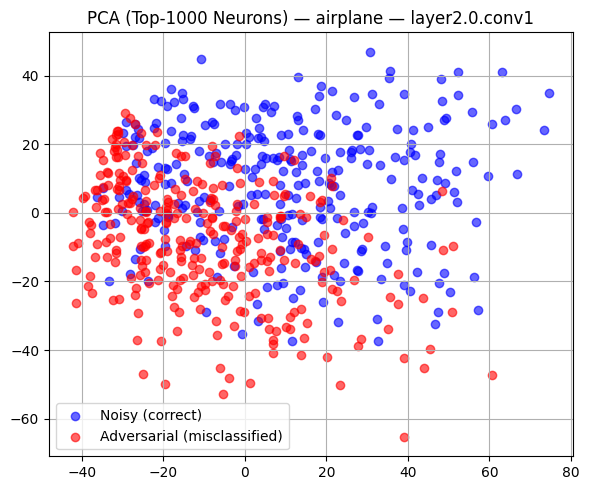

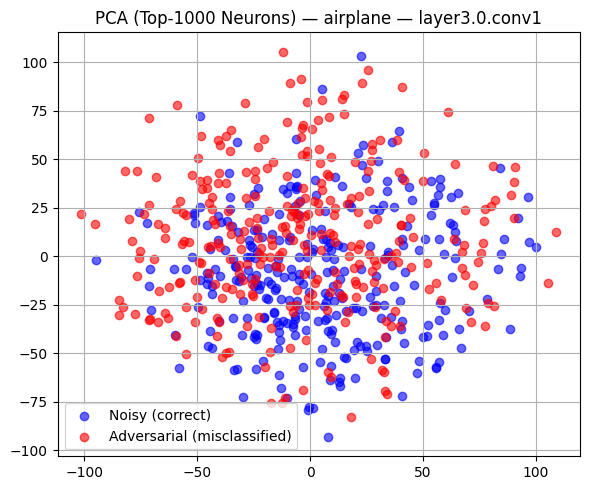

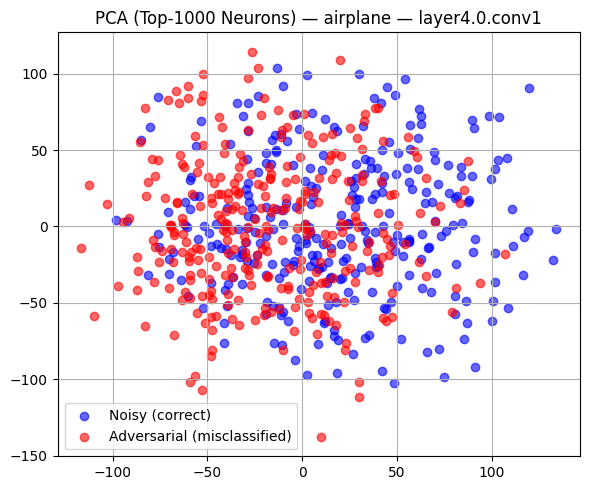

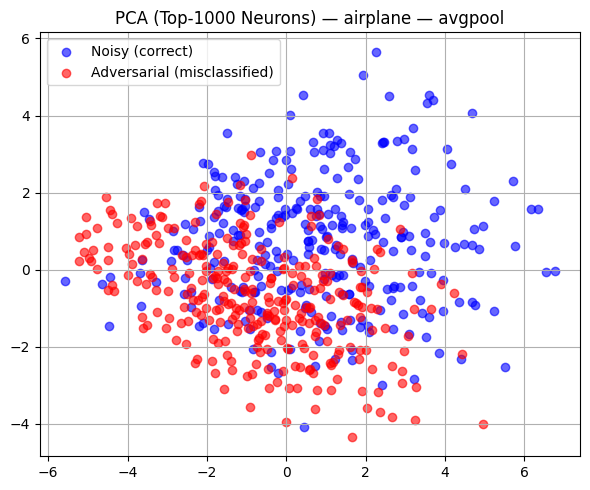

In [ ]:
# Make sure to define your target class and get its index
target_class = "airplane"
target_class_index = class_names.index(target_class)

# Now call the function using your model + data
plot_classwise_misclassification_pca_topk_flat(
    sae_dict=sae_dict,
    extractor=extractor,
    model=model,
    noisy_loader=noisy_loader,
    adv_loader=adv_loader,
    target_class_index=target_class_index,
    class_names=class_names,
    max_samples=300,     # Number of clean + adv samples to use
    top_k=1000           # Top-k neurons to select based on clean activation
)


In [ ]:
def plot_classwise_misclassification_lda_kde_topk_flat(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, max_samples=300, top_k=100
):
    import torch
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

    def get_filtered_latents(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue
                feats = extractor(imgs[mask])
                z = sae.relu1(sae.encoder(feats[layer_name]))
                z = z.flatten(start_dim=1).cpu()
                zs.append(z)
                if sum(z.shape[0] for z in zs) >= max_samples:
                    break
        return torch.cat(zs, dim=0) if zs else torch.empty(0, 0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        z_noisy = get_filtered_latents(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )
        z_adv = get_filtered_latents(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if z_noisy.shape[0] == 0 or z_adv.shape[0] == 0:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        # Get top-k neurons based on clean class
        mean_clean = z_noisy.mean(dim=0)
        top_indices = torch.topk(mean_clean, k=top_k).indices

        z_noisy_top = z_noisy[:, top_indices]
        z_adv_top = z_adv[:, top_indices]
        combined = torch.cat([z_noisy_top, z_adv_top], dim=0)

        labels = torch.cat([
            torch.zeros(z_noisy_top.shape[0]),
            torch.ones(z_adv_top.shape[0])
        ])

        lda = LinearDiscriminantAnalysis(n_components=1)
        embedded = lda.fit_transform(combined.numpy(), labels.numpy())

        n = z_noisy_top.shape[0]
        plt.figure(figsize=(8, 2))
        sns.kdeplot(embedded[:n, 0], fill=True, label='Noisy (correct)', color='blue')
        sns.kdeplot(embedded[n:, 0], fill=True, label='Adversarial (misclassified)', color='red')
        plt.title(f"LDA KDE (Top-{top_k} Neurons) — {class_names[target_class_index]} — {layer_name}")
        plt.xlabel("LDA Projection")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


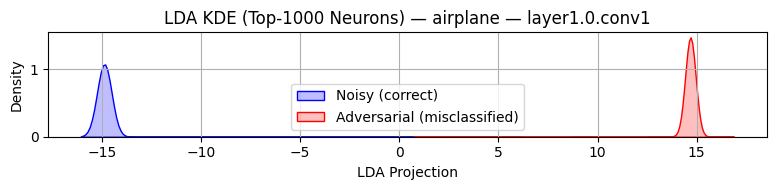

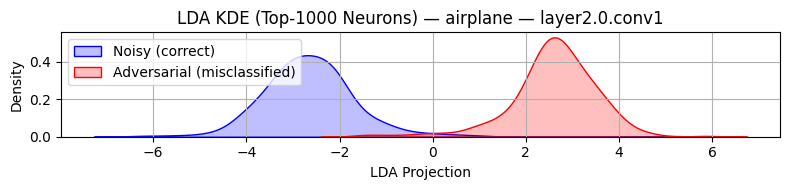

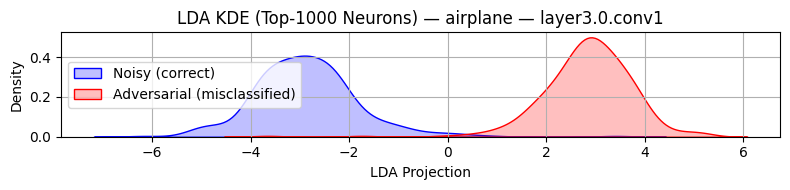

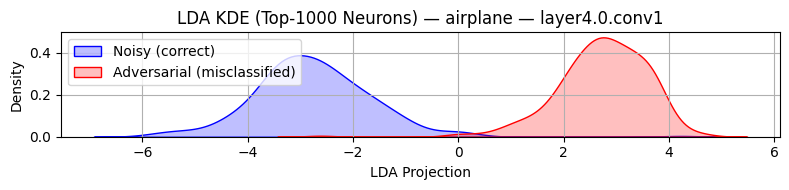

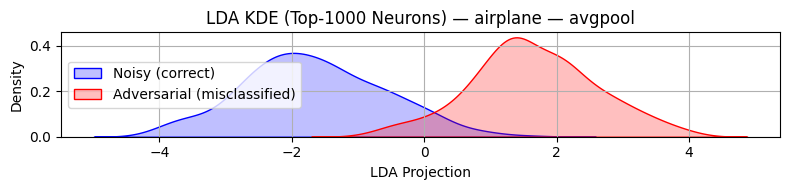

In [ ]:
# Make sure to define your target class and get its index
target_class = "airplane"
target_class_index = class_names.index(target_class)

# Now call the function using your model + data
plot_classwise_misclassification_lda_kde_topk_flat(
    sae_dict=sae_dict,
    extractor=extractor,
    model=model,
    noisy_loader=noisy_loader,
    adv_loader=adv_loader,
    target_class_index=target_class_index,
    class_names=class_names,
    max_samples=300,     # Number of clean + adv samples to use
    top_k=1000           # Top-k neurons to select based on clean activation
)


In [ ]:
def plot_lda_vs_pca_topk_flat(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, max_samples=300, top_k=100
):
    import torch
    import matplotlib.pyplot as plt
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.decomposition import PCA

    def get_filtered_latents(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                feats = extractor(imgs[mask])
                z = sae.relu1(sae.encoder(feats[layer_name]))
                z = z.flatten(start_dim=1).cpu()
                zs.append(z)

                if sum(z.shape[0] for z in zs) >= max_samples:
                    break
        return torch.cat(zs, dim=0) if zs else torch.empty(0, 0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        z_noisy = get_filtered_latents(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )
        z_adv = get_filtered_latents(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if z_noisy.shape[0] == 0 or z_adv.shape[0] == 0:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        mean_clean = z_noisy.mean(dim=0)
        top_indices = torch.topk(mean_clean, k=top_k).indices
        z_noisy_top = z_noisy[:, top_indices]
        z_adv_top = z_adv[:, top_indices]
        combined = torch.cat([z_noisy_top, z_adv_top], dim=0)

        labels = torch.cat([
            torch.zeros(z_noisy_top.shape[0]),
            torch.ones(z_adv_top.shape[0])
        ]).numpy()

        # 1D LDA
        lda = LinearDiscriminantAnalysis(n_components=1)
        lda_proj = lda.fit_transform(combined.numpy(), labels).flatten()

        # 1D PCA
        pca = PCA(n_components=1)
        pca_proj = pca.fit_transform(combined.numpy()).flatten()

        n = z_noisy_top.shape[0]
        plt.figure(figsize=(6, 5))
        plt.scatter(pca_proj[:n], lda_proj[:n], color='blue', label='Noisy (correct)', alpha=0.6)
        plt.scatter(pca_proj[n:], lda_proj[n:], color='red', label='Adversarial (misclassified)', alpha=0.6)
        plt.xlabel("1st Principal Component")
        plt.ylabel("LDA Projection")
        plt.title(f"1D PCA vs LDA (Top-{top_k}) — {class_names[target_class_index]} — {layer_name}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


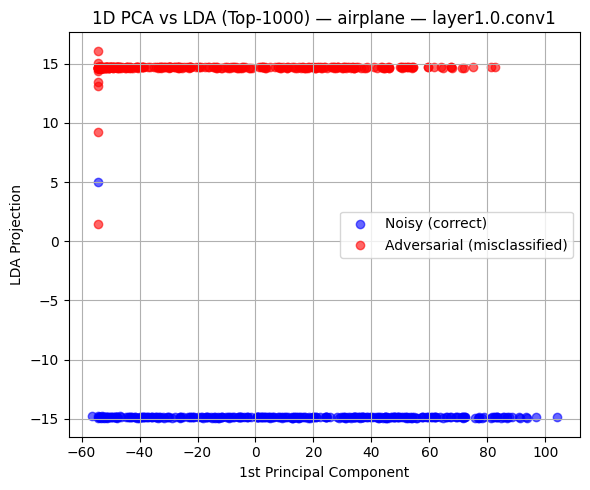

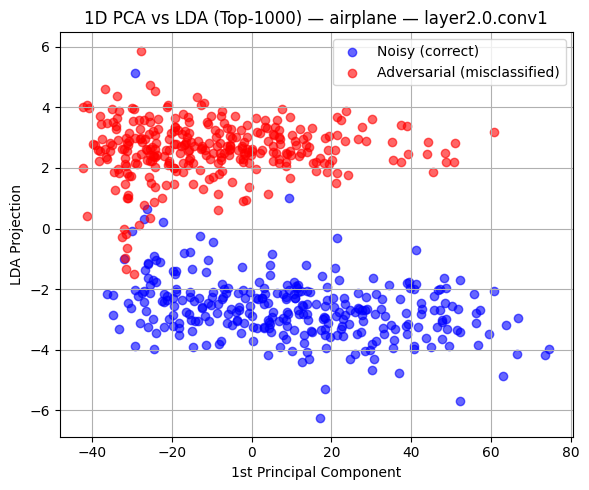

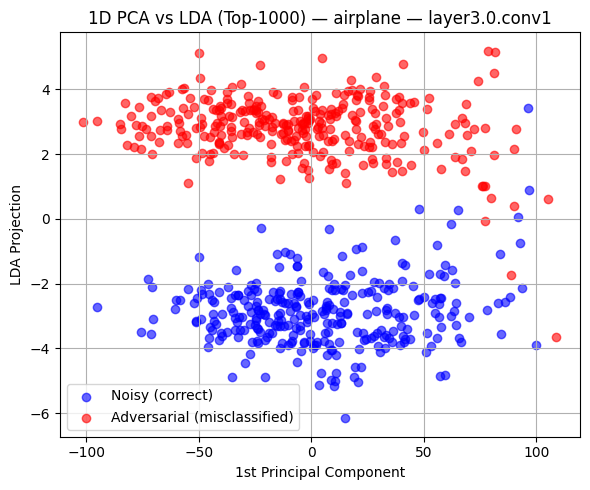

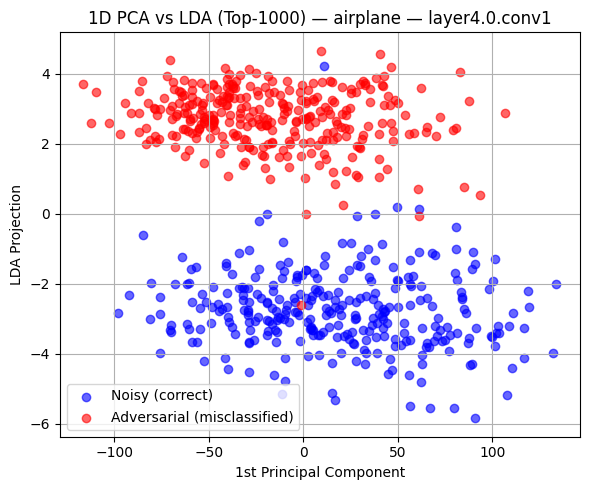

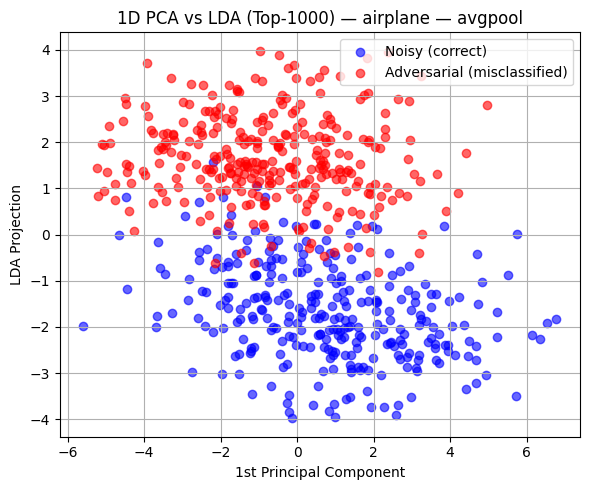

In [ ]:
# Make sure to define your target class and get its index
target_class = "airplane"
target_class_index = class_names.index(target_class)

# Now call the function using your model + data
plot_lda_vs_pca_topk_flat(
    sae_dict=sae_dict,
    extractor=extractor,
    model=model,
    noisy_loader=noisy_loader,
    adv_loader=adv_loader,
    target_class_index=target_class_index,
    class_names=class_names,
    max_samples=300,     # Number of clean + adv samples to use
    top_k=1000           # Top-k neurons to select based on clean activation
)


# Top 1000 Neurons from Adversary

In [ ]:
def plot_classwise_misclassification_tsne_topk_adv(
    sae_dict, extractor, model, noisy_loader, adv_loader,
    target_class_index, class_names, max_samples=300, top_k=100
):
    import torch
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    def get_filtered_latents(sae, layer_name, loader, condition_fn):
        zs = []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to("cuda:0"), labels.to("cuda:0")
                preds = model(imgs).argmax(dim=1)
                mask = condition_fn(preds, labels)
                if not mask.any(): continue

                feats = extractor(imgs[mask])
                z = sae.relu1(sae.encoder(feats[layer_name]))  # [B, C, H, W]
                z = z.flatten(start_dim=1)                     # [B, C*H*W]
                zs.append(z.cpu())

                if sum(z.shape[0] for z in zs) >= max_samples:
                    break
        return torch.cat(zs, dim=0) if zs else torch.empty(0, 0)

    for layer_name in sae_dict:
        sae = sae_dict[layer_name]

        z_noisy = get_filtered_latents(
            sae, layer_name, noisy_loader,
            lambda pred, true: (pred == target_class_index) & (true == target_class_index)
        )
        z_adv = get_filtered_latents(
            sae, layer_name, adv_loader,
            lambda pred, true: (pred == target_class_index) & (true != target_class_index)
        )

        if z_noisy.shape[0] == 0 or z_adv.shape[0] == 0:
            print(f"[{layer_name}] Skipping — not enough samples for class '{class_names[target_class_index]}'")
            continue

        # 🧠 Select top-k neuron indices based on **adversarial** activations
        mean_adv = z_adv.mean(dim=0)
        top_indices = torch.topk(mean_adv, k=top_k).indices

        z_noisy_top = z_noisy[:, top_indices]
        z_adv_top = z_adv[:, top_indices]
        combined = torch.cat([z_noisy_top, z_adv_top], dim=0)

        tsne = TSNE(n_components=2, perplexity=10, init='pca', random_state=42, early_exaggeration=24)
        embedded = tsne.fit_transform(combined)

        n = z_noisy_top.shape[0]
        plt.figure(figsize=(6, 5))
        plt.scatter(embedded[:n, 0], embedded[:n, 1], label='Noisy (correct)', color='blue', alpha=0.6)
        plt.scatter(embedded[n:, 0], embedded[n:, 1], label='Adversarial (misclassified)', color='red', alpha=0.6)
        plt.title(f"t-SNE (Top-{top_k} Neurons by Adv) — {class_names[target_class_index]} — {layer_name}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


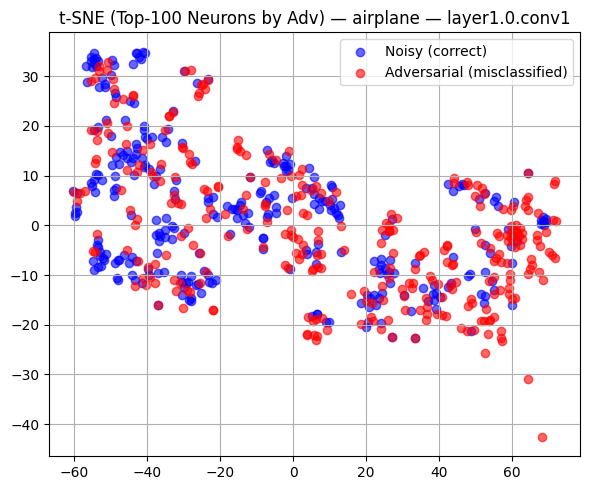

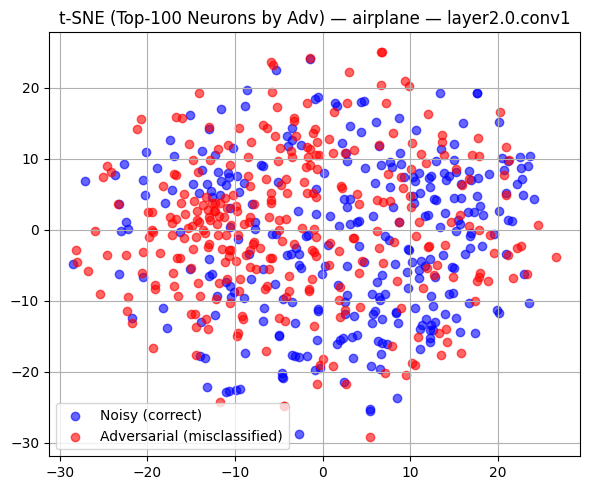

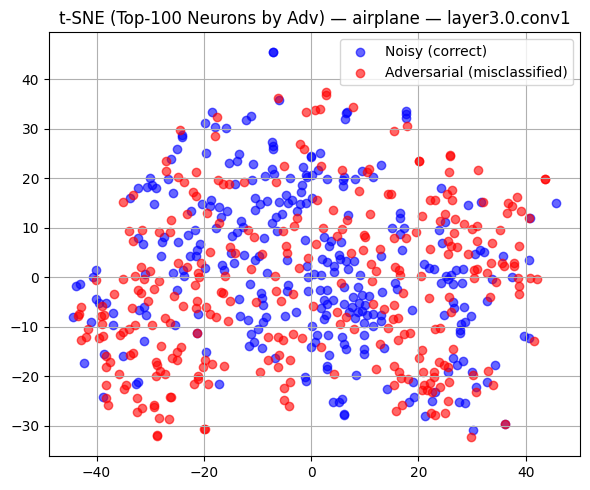

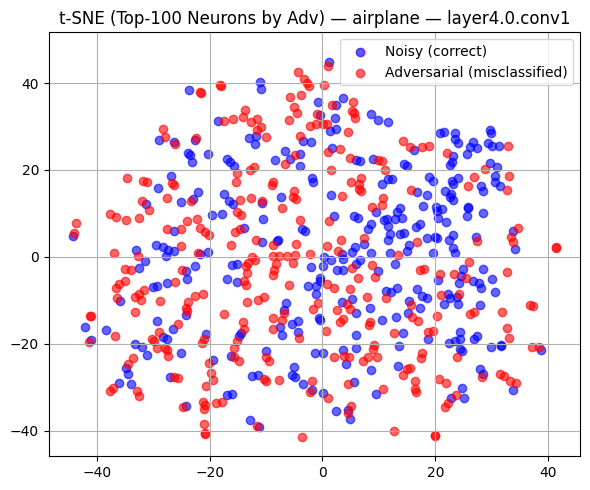

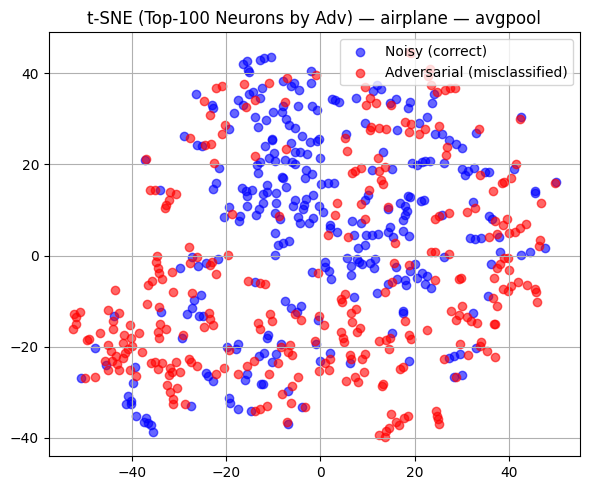

In [ ]:
# Make sure to define your target class and get its index
target_class = "airplane"
target_class_index = class_names.index(target_class)

# Now call the function using your model + data
plot_classwise_misclassification_tsne_topk_adv(
    sae_dict=sae_dict,
    extractor=extractor,
    model=model,
    noisy_loader=noisy_loader,
    adv_loader=adv_loader,
    target_class_index=target_class_index,
    class_names=class_names,
    max_samples=300,     # Number of clean + adv samples to use
    top_k=100            # Top-k neurons to select based on clean activation
)


# Hyperparameter Sweep

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import umap
from tqdm import tqdm
import numpy as np

# Assuming SelectiveLayerExtractor and OvercompleteSparseAutoencoder are defined above

def sweep_sae_clustering(
    model, held_out_loader, noisy_loader, adv_loader,
    layers_to_hook, alphas, overcomplete_factors,
    max_samples=300, pooling_size=(16, 16)
):
    device = next(model.parameters()).device
    extractor = SelectiveLayerExtractor(model, layers_to_hook).to(device)
    model.eval()

    results = []

    for alpha in alphas:
        for overcomplete_factor in overcomplete_factors:
            print(f"Running sweep: alpha={alpha}, overcomplete={overcomplete_factor}")

            sae_dict = {}
            optimizer_dict = {}
            criterion = nn.MSELoss()

            # Initialize SAEs
            with torch.no_grad():
                for imgs, _ in held_out_loader:
                    imgs = imgs.to(device)
                    feats = extractor(imgs)
                    for name, feat in feats.items():
                        C = feat.shape[1]
                        sae = OvercompleteSparseAutoencoder(C, overcomplete_factor).to(device)
                        sae_dict[name] = sae
                        optimizer_dict[name] = optim.Adam(sae.parameters(), lr=1e-3)
                    break

            # Train SAEs
            for epoch in range(20):  # shorter for sweep
                for imgs, _ in held_out_loader:
                    imgs = imgs.to(device)
                    feats = extractor(imgs)
                    for name in sae_dict:
                        feature = feats[name]
                        sae = sae_dict[name]
                        optimizer = optimizer_dict[name]

                        recon, latent = sae(feature)
                        loss_recon = criterion(recon, feature)
                        loss_sparse = alpha * latent.abs().mean()
                        loss = loss_recon + loss_sparse

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

            # Evaluate clustering separation
            for name in sae_dict:
                sae = sae_dict[name]
                pool = nn.AdaptiveAvgPool2d(pooling_size)

                def get_latents(loader, condition_fn):
                    zs = []
                    with torch.no_grad():
                        for imgs, labels in loader:
                            imgs, labels = imgs.to(device), labels.to(device)
                            feats = extractor(imgs)
                            outputs = model(imgs)
                            preds = outputs.argmax(dim=1)

                            mask = condition_fn(preds, labels)
                            if not mask.any(): continue

                            imgs = imgs[mask]
                            feats = extractor(imgs)
                            z = sae.relu1(sae.encoder(feats[name]))
                            z = pool(z)
                            z = z.flatten(start_dim=1)
                            zs.append(z.cpu())

                            if sum(z.shape[0] for z in zs) >= max_samples:
                                break
                    return torch.cat(zs, dim=0)

                z_noisy = get_latents(noisy_loader, lambda p, t: (p == t))
                z_adv = get_latents(adv_loader, lambda p, t: (p != t))

                if len(z_noisy) == 0 or len(z_adv) == 0:
                    continue

                combined = torch.cat([z_noisy, z_adv], dim=0)
                labels = [0] * len(z_noisy) + [1] * len(z_adv)

                reducer = umap.UMAP(
                    n_components=2,
                    n_neighbors=5,
                    min_dist=0.01,
                    spread=1.0,
                    metric='euclidean',
                    random_state=42
                )
                embedded = reducer.fit_transform(combined.numpy())
                score = silhouette_score(embedded, labels)
                results.append((alpha, overcomplete_factor, name, score))
                print(f"[{name}] alpha={alpha}, overcomplete={overcomplete_factor}, silhouette={score:.3f}")

    return results

# Example call
results = sweep_sae_clustering(model, held_out_loader, noisy_loader, adv_loader,
                                layers_to_hook=['layer1.0.conv1', 'layer2.0.conv1'],
                                alphas=[1e-3, 1e-2, 0.1, 0.5, 0.7, 0.9],
                                overcomplete_factors=[4, 8, 16, 32])

# Classifier

In [ ]:
held_out_loader

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def pgd_attack(model, images, labels, epsilon, alpha=0.005, iters=10, device="cuda:0"):
    """
    Performs a PGD adversarial attack (L-infinity norm).
    """
    ori = images.clone().detach().to(device)
    img = ori.clone()
    labels = labels.to(device)
    for _ in range(iters):
        img.requires_grad_(True)
        outputs = model(img)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = img.grad.data.sign()
        img = (img + alpha * grad).detach()
        # Project back into the epsilon-ball
        diff = torch.clamp(img - ori, min=-epsilon, max=epsilon)
        img = torch.clamp(ori + diff, 0, 1)
    return img.detach()

def prepare_and_train_detector_pgd(
    held_out,           # Dataset or DataLoader of (img, label)
    sae_dict,           # dict[layer_name] = SAE module
    extractor,          # fn imgs->feature dict
    model,              # classification model
    epsilon=0.03,
    alpha=0.005,
    iters=10,
    batch_size=64,
    max_samples=1000,
    top_k=1000,
    device="cuda:0"
):
    # If a DataLoader was passed, extract its dataset
    if isinstance(held_out, DataLoader):
        dataset = held_out.dataset
    else:
        dataset = held_out

    # 1) Split 50/10/10/30
    N = len(dataset)
    n50  = int(0.5 * N)
    n10a = int(0.1 * N)
    n10b = int(0.1 * N)
    n30  = N - (n50 + n10a + n10b)
    train_ds, val_ds, test_ds, mean_ds = random_split(
        dataset, [n50, n10a, n10b, n30]
    )
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
    mean_loader  = DataLoader(mean_ds,  batch_size=batch_size, shuffle=False)

    device = torch.device(device)
    model.to(device).eval()

    # 2) PGD attack will be used for adversarial examples

    # 3) Compute global clean mean on the 30% “mean” split, first SAE layer
    first_layer = next(iter(sae_dict.keys()))
    sae0 = sae_dict[first_layer].to(device).eval()

    all_z = []
    with torch.no_grad():
        for imgs, _ in mean_loader:
            imgs = imgs.to(device)
            feats = extractor(imgs)
            z = sae0.relu1(sae0.encoder(feats[first_layer]))  # [B, C, H, W]
            z = z.flatten(start_dim=1)                        # [B, D]
            all_z.append(z.cpu())
            if sum(x.shape[0] for x in all_z) >= max_samples:
                break

    all_z = torch.cat(all_z, dim=0)    # [M, D]
    mean_z = all_z.mean(dim=0)         # [D]

    # 4) Select top_k neurons by that clean mean
    topk = torch.topk(mean_z, k=top_k).indices  # [top_k]

    # 5) Build feature matrix (delta) and labels
    def build_xy(loader):
        X_parts, y_parts = [], []
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # -- Clean forward --
            with torch.no_grad():
                feats = extractor(imgs)
                zc = sae0.relu1(sae0.encoder(feats[first_layer])).flatten(1)
            dc = (zc - mean_z.to(device))[:, topk].cpu()

            # -- Adversarial forward using PGD --
            adv_imgs = pgd_attack(model, imgs, labels, epsilon, alpha, iters, device)
            with torch.no_grad():
                feats2 = extractor(adv_imgs)
                za = sae0.relu1(sae0.encoder(feats2[first_layer])).flatten(1)
            da = (za - mean_z.to(device))[:, topk].cpu()

            X_parts.append(dc); y_parts.extend([0]*dc.shape[0])
            X_parts.append(da); y_parts.extend([1]*da.shape[0])

        X = torch.cat(X_parts, dim=0).numpy()
        y = torch.tensor(y_parts).numpy()
        return X, y

    # 6) Build train/val/test
    X_train, y_train = build_xy(train_loader)
    X_val,   y_val   = build_xy(val_loader)
    X_test,  y_test  = build_xy(test_loader)

    # 7) Train a logistic‐regression adversary detector
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # 8) Evaluate
    for split, X, y in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
        preds = clf.predict(X)
        acc = accuracy_score(y, preds)
        print(f"{split} accuracy: {acc:.4f}")

    return clf, topk, mean_z

clf, topk, mean_z = prepare_and_train_detector_pgd(
    held_out_loader, sae_dict, extractor, model,
    epsilon=0.03, alpha=0.005, iters=10,
    batch_size=64, max_samples=1000, top_k=1000, device="cuda:0"
)


VAL accuracy: 0.9553
TEST accuracy: 0.9463


In [ ]:
pip install torchattacks

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchattacks import CW, DeepFool, AutoAttack
# Detector evaluation function

first_layer = next(iter(sae_dict.keys()))
sae0 = sae_dict[first_layer].to(device).eval()

def evaluate_detector(
    clf, topk, mean_z, first_layer, sae0,
    extractor, model, loader,
    attack_fn, attack_name, epsilon,
    device="cuda:0"
):
    model.to(device).eval()
    sae0.to(device).eval()
    # Counters for clean and adversarial
    clean_correct = clean_total = adv_correct = adv_total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # -- Clean forward --
        with torch.no_grad():
            feats = extractor(imgs)
            zc = sae0.relu1(sae0.encoder(feats[first_layer])).flatten(1)
        dc = (zc - mean_z.to(device))[:, topk].cpu().numpy()

        # -- Adversarial forward --
        adv_imgs = attack_fn(model, imgs, labels, epsilon)
        with torch.no_grad():
            feats2 = extractor(adv_imgs)
            za = sae0.relu1(sae0.encoder(feats2[first_layer])).flatten(1)
        da = (za - mean_z.to(device))[:, topk].cpu().numpy()

        # Predictions
        pred_clean = clf.predict(dc)
        pred_adv = clf.predict(da)

        # Update counters
        clean_total += len(pred_clean)
        clean_correct += (pred_clean == 0).sum()
        adv_total += len(pred_adv)
        adv_correct += (pred_adv == 1).sum()

    # Totals
    total = clean_total + adv_total
    correct = clean_correct + adv_correct

    # Print results
    print(f"{attack_name} clean detection: {clean_correct}/{clean_total} = {clean_correct/clean_total:.4f}")
    print(f"{attack_name} adversarial detection: {adv_correct}/{adv_total} = {adv_correct/adv_total:.4f}")
    print(f"{attack_name} total detection: {correct}/{total} = {correct/total:.4f}\n")

# ——— Instantiate attacks ———
# assume `model` is on CUDA: model.to("cuda:0")

# Carlini–Wagner ℓ₂
cw = CW(model, c=1e-4, kappa=0, steps=1000)
# DeepFool
deepfool = DeepFool(model, steps=50)
# AutoAttack standard (ℓ∞)
auto_std = AutoAttack(model, norm='Linf', eps=0.03, version='standard')
# AutoAttack plus (ℓ∞)
auto_plus = AutoAttack(model, norm='Linf', eps=0.03, version='plus')

# ——— Run evaluations ———

# BIM (PGD w/o random start)
evaluate_detector(
    clf, topk, mean_z, first_layer, sae0,
    extractor, model, val_loader,
    attack_fn=lambda m,x,y,eps: pgd_attack(m, x, y, eps, alpha=eps/10, iters=10),
    attack_name="BIM (PGD)", epsilon=0.03
)

# Carlini–Wagner ℓ₂
evaluate_detector(
    clf, topk, mean_z, first_layer, sae0,
    extractor, model, val_loader,
    attack_fn=lambda m,x,y,eps: cw(x, y),
    attack_name="CW‑L2", epsilon=0.03
)

# DeepFool
evaluate_detector(
    clf, topk, mean_z, first_layer, sae0,
    extractor, model, val_loader,
    attack_fn=lambda m,x,y,eps: deepfool(x, y),
    attack_name="DeepFool", epsilon=0.03
)

BIM (PGD) clean detection: 6711/7000 = 0.9587
BIM (PGD) adversarial detection: 6668/7000 = 0.9526
BIM (PGD) total detection: 13379/14000 = 0.9556

CW‑L2 clean detection: 6711/7000 = 0.9587
CW‑L2 adversarial detection: 4682/7000 = 0.6689
CW‑L2 total detection: 11393/14000 = 0.8138

DeepFool clean detection: 6711/7000 = 0.9587
DeepFool adversarial detection: 6037/7000 = 0.8624
DeepFool total detection: 12748/14000 = 0.9106



AttributeError: 'AutoAttack' object has no attribute 'run_standard_evaluation'